# Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the libraries
pd.set_option("max_columns",None)
pd.set_option("max_rows",None)


from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest, f_classif
from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway

from scipy import stats
from scipy.stats import norm, skew,skewtest
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import scorecardpy as sc

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler, OneHotEncoder, MaxAbsScaler, RobustScaler, PowerTransformer

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support 
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn.linear_model import Ridge, Lasso, LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import AdaBoostClassifier

from itertools import combinations
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn import tree as tr

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,plot_confusion_matrix,f1_score

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
import random

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


# Load Dataset

DISCLAIMER!

untuk dataset, yang saya gunakan hanya **'application_train'** saja untuk keperluan train model nya, 
sedangkan  dataset **'application_test'** saya cek tidak memiliki label, saya berasumsi bahwa dataset **'application_test'** digunakan untuk keperluan **'BACKTESTING'**.

untuk dataset lain yang disediakan, dalam best practicenya machine learning menggunakan data - data historis untuk train modelnya. jadi sebenarnya dataset lain harusnya di merge dengan dataset **'application_train'**, setelah saya proses ternyata dimensi dataset menjadi sangat besar yaitu sekitar ada **'700 feature'** dan **'350.000 rows'**, yang membuat laptop ataupun google collab saya tidak bisa memproses fitting ke model, karna dimensinya terlalu besar. saya juga sudah berupaya menggunakan beberapa tehnik yang sering dipakai kalau dimensi terlalu besar yaitu **'PCA'**, **'TruncatedSVD'**, dll, ternyata tidak memberikan hasil yang signifikan juga. setelah melihat hasil **'WOE-IV'** juga ternyata fitur-fitur berpengaruh masih banyak terdapat pada **'application_train'** dataset, jadi saya putuskan dataset yang lain tidak saya pakai. hanya menggunakan 'application_train'.

In [3]:
# Preprocess application_train.csv
df = pd.read_csv('/content/drive/MyDrive/Home Credit Rakamin/home-credit-default-risk/application_train.csv')

# untuk backtesting
#df_test= pd.read_csv('/content/drive/MyDrive/Home Credit Rakamin/home-credit-default-risk/application_test.csv')

# Optional: Remove 4 applications with XNA CODE_GENDER (train set), remove the id customer, and organization type
df = df.drop(['SK_ID_CURR','ORGANIZATION_TYPE'],axis=1)
df = df[df['CODE_GENDER'] != 'XNA']

In [4]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,

# Data Preprocessing

In [5]:
df.shape

(307507, 120)

In [6]:
df['TARGET'].value_counts()

0    282682
1     24825
Name: TARGET, dtype: int64

In [7]:
df.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307507.00000,307507.000000,3.075070e+05,3.075070e+05,307495.000000,3.072290e+05,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,104580.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307505.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,134131.000000,3.068470e+05,246542.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,151447.000000,127565.000000,157501.000000,103021.000000,92645.000000,143617.000000,152680.000000,154488.000000,98867.000000,124919.000000,97310.000000,153158.000000,93995.000000,137827.000000,159077.000000,306486.000000,306486.000000,306486.000000,306486.000000,307506.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.00000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,307507.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000,265988.000000
mean,0.08073,0.417047,1.687977e+05,5.990286e+05,27108.666786,5.383977e+05,0.020868,-16037.027271,63815.929208,-4986.131376,-2994.201670,12.061121,0.999997,0.819887,0.199358,0.998133,0.281057,0.056721,2.152658,2.052461,2.031518,12.063394,0.015144,0.050770,0.040659,0.078174,0.230457,0.179557,0.502129,5.143918e-01,0.510856,0.117442,0.088443,0.977735,0.752472,0.044621,0.078943,0.149726,0.226284,0.231897,0.066334,0.100776,0.107400,0.008809,0.028358,0.114232,0.087543,0.977065,0.759637,0.042554,0.074491,0.145194,0.222317,0.228061,0.064958,0.105646,0.105976,0.008077,0.027023,0.117851,0.087955,0.977752,0.755746,0.044596,0.078079,0.14921

In [8]:
df['DAYS_EMPLOYED'].describe()

count    307507.000000
mean      63815.929208
std      141276.472519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [9]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
# Some simple new features (percentages)

df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


In [10]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value = missing_value_df[missing_value_df['percent_missing']>30]
missing_value

,column_name,percent_missing
OWN_CAR_AGE,OWN_CAR_AGE,65.991018
OCCUPATION_TYPE,OCCUPATION_TYPE,31.345303
EXT_SOURCE_1,EXT_SOURCE_1,56.381156
APARTMENTS_AVG,APARTMENTS_AVG,50.750064
BASEMENTAREA_AVG,BASEMENTAREA_AVG,58.516391
YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_AVG,48.781329
YEARS_BUILD_AVG,YEARS_BUILD_AVG,66.497998
COMMONAREA_AVG,COMMONAREA_AVG,69.872231
ELEVATORS_AVG,ELEVATORS_AVG,53.296348
ENTRANCES_AVG,ENTRANCES_AVG,50.349098


Data Quality Report : <br>
- seperti yang terlihat pada data, terdapat beberapa kolom yang memiliki **missing value > 30%**, serta terdapat anomali data pada salah satu kolom yaitu **DAYS_EMPLOYED** dan untuk data label sangat **'imbalance'**. hal ini mungkin terjadi karena beberapa hal. <br> <br>
- salah satunya adalah kesalahan merge kolom, pada saat penarikan data dari database oleh data engineer, sehingga perlu di pertanyakan kepada data engineer terkait kasus ini. <br>


- ada beberapa proses yang akan dilakukan.
> 1. untuk missing value > 30%, akan di drop, sedangkan missing value < 30%, akan dilakukan imputation dengan fillna (0) untuk feature yang hanya berisi nilai binner saja dan beberapa di fillna dengan nilai mediannya karna berisi nilai numeric. <br><br>
> 2. anomali data akan di treat sebagai missing value. <br><br>
> 3. imbalance data, akan di proses lebih lanjut pada saat fitting model dengan Random Over Sampling dan Random Under Sampling method. <br><br>
> 4. beberapa kolom tidak relevan dalam faktor yang menentukan ciri khas yang menentukan seorang nasabah dapat membayar pinjaman atau tidak sehingga beberapa kolom yang di rasa tidak relevan akan diremove.

In [11]:
df.drop(columns=missing_value['column_name'], inplace=True, axis=1)
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,2.0,1,1,MONDAY,11,0,0,0,0,0,0,0.622246,NaN,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,1,1,1,1,1,0,1.0,2,2,MONDAY,9,0,0,0,0,0,0,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039.0,-9833.0,-2437,1,1,0,1,0,0,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,0.650442,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038.0,-4311.0,-3458,1,1,0,1,0,0,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,0.322738,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [12]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value = missing_value_df[missing_value_df['percent_missing']>0]
missing_value

,column_name,percent_missing
AMT_ANNUITY,AMT_ANNUITY,0.003902
AMT_GOODS_PRICE,AMT_GOODS_PRICE,0.090404
NAME_TYPE_SUITE,NAME_TYPE_SUITE,0.420153
DAYS_EMPLOYED,DAYS_EMPLOYED,18.007395
CNT_FAM_MEMBERS,CNT_FAM_MEMBERS,0.000650
EXT_SOURCE_2,EXT_SOURCE_2,0.214629
EXT_SOURCE_3,EXT_SOURCE_3,19.825565
OBS_30_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.332025
DEF_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,0.332025
OBS_60_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,0.332025


In [13]:
df['AMT_ANNUITY'] = df['AMT_ANNUITY'].fillna(df['AMT_ANNUITY'].median())
df['AMT_GOODS_PRICE'] = df['AMT_GOODS_PRICE'].fillna(df['AMT_GOODS_PRICE'].median())
df['CNT_FAM_MEMBERS'] = df['CNT_FAM_MEMBERS'].fillna(0)
df['EXT_SOURCE_2'] = df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].median())
df['EXT_SOURCE_3'] = df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].median())
df['OBS_30_CNT_SOCIAL_CIRCLE'] = df['OBS_30_CNT_SOCIAL_CIRCLE'].fillna(0)
df['DEF_30_CNT_SOCIAL_CIRCLE'] = df['DEF_30_CNT_SOCIAL_CIRCLE'].fillna(0)
df['OBS_60_CNT_SOCIAL_CIRCLE'] = df['OBS_60_CNT_SOCIAL_CIRCLE'].fillna(0)
df['DEF_60_CNT_SOCIAL_CIRCLE'] = df['DEF_60_CNT_SOCIAL_CIRCLE'].fillna(0)
df['DAYS_LAST_PHONE_CHANGE'] = df['AMT_GOODS_PRICE'].fillna(df['DAYS_LAST_PHONE_CHANGE'].median())
df['AMT_REQ_CREDIT_BUREAU_HOUR'] = df['AMT_REQ_CREDIT_BUREAU_HOUR'].fillna(0)
df['AMT_REQ_CREDIT_BUREAU_DAY'] = df['AMT_REQ_CREDIT_BUREAU_DAY'].fillna(0)
df['AMT_REQ_CREDIT_BUREAU_WEEK'] = df['AMT_REQ_CREDIT_BUREAU_WEEK'].fillna(0)
df['AMT_REQ_CREDIT_BUREAU_MON'] = df['AMT_REQ_CREDIT_BUREAU_MON'].fillna(0)
df['AMT_REQ_CREDIT_BUREAU_QRT'] = df['AMT_REQ_CREDIT_BUREAU_QRT'].fillna(0)
df['AMT_REQ_CREDIT_BUREAU_YEAR'] = df['AMT_REQ_CREDIT_BUREAU_YEAR'].fillna(0)
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].fillna(df['DAYS_EMPLOYED'].median())
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED_PERC'].fillna(df['DAYS_EMPLOYED_PERC'].median())
df['INCOME_PER_PERSON'] = df['INCOME_PER_PERSON'].fillna(df['INCOME_PER_PERSON'].median())
df['ANNUITY_INCOME_PERC'] = df['ANNUITY_INCOME_PERC'].fillna(df['ANNUITY_INCOME_PERC'].median())
df['PAYMENT_RATE'] = df['PAYMENT_RATE'].fillna(df['PAYMENT_RATE'].median())

df['NAME_TYPE_SUITE'] = df['NAME_TYPE_SUITE'].fillna(df['NAME_TYPE_SUITE'].value_counts().index[0])

In [14]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value = missing_value_df[missing_value_df['percent_missing']>0]
missing_value

,column_name,percent_missing


In [15]:
df.shape

(307507, 75)

# Feature Selection Based on WOE-IV

Feature selection dalam best practice, harusnya dilakukan sesudah train_test_split, tapi sekarang saya lakukan sebelum train_test_split. ini salah satu langkah yang saya lakukan untuk mengurangi dimensi data, selain menggunakan PCA dan  TruncatedSVD, jadi hanya best feature saja yang akan dipakai. yang bernilai 'Useless' akan di drop. 

In [16]:
#categoric fitur dan continuous fiture

class CategoricalFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature

    @property
    def df_lite(self):
        df_lite = self.df
        df_lite['bin'] = df_lite[self.feature].fillna('MISSING')
        return df_lite[['bin', 'TARGET']]


class ContinuousFeature():
    def __init__(self, df, feature):
        self.df = df
        self.feature = feature
        self.bin_min_size = int(len(self.df) * 0.05)

    def __generate_bins(self, bins_num):
        df = self.df[[self.feature, 'TARGET']]
        df['bin'] = pd.qcut(df[self.feature], bins_num, duplicates='drop') \
                    .apply(lambda x: x.left) \
                    .astype(float)
        return df

    def __generate_correct_bins(self, bins_max=20):
        for bins_num in range(bins_max, 1, -1):
            df = self.__generate_bins(bins_num)
            df_grouped = pd.DataFrame(df.groupby('bin') \
                                      .agg({self.feature: 'count',
                                            'TARGET': 'sum'})) \
                                      .reset_index()
            r, p = stats.stats.spearmanr(df_grouped['bin'], df_grouped['TARGET'])

            if (
                    abs(r)==1 and                                                        # periksa apakah WOE untuk tiap bin adalah monotomic
                    df_grouped[self.feature].min() > self.bin_min_size                   # periksa apakah size setiap bin besar dari 5%
                    and not (df_grouped[self.feature] == df_grouped['TARGET']).any()      # periksa apakah label Yes dan No jumlahnya adalah 0
            ):
                break

        return df

    @property
    def df_lite(self):
        df_lite = self.__generate_correct_bins()
        df_lite['bin'].fillna('MISSING', inplace=True)
        return df_lite[['bin', 'TARGET']]

In [17]:
# Information Value
pd.set_option('mode.chained_assignment', None)

class AttributeRelevance():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def bulk_iv(self, feats, iv, woe_extremes=False):
        iv_dict = {}
        for f in feats:
            iv_df, iv_value = iv.calculate_iv(f)
            if woe_extremes:
                iv_dict[f.feature] = [iv_value, iv_df['woe'].min(), iv_df['woe'].max()]
                cols = ['iv', 'woe_min', 'woe_max']
            else:
                iv_dict[f.feature] = iv_value
                cols = ['iv']
        df = pd.DataFrame.from_dict(iv_dict, orient='index', columns=cols)
        return df

    def bulk_stats(self, feats, s):
        stats_dict = {}
        for f in feats:
            p_value, effect_size = s.calculate_chi(f)
            stats_dict[f.feature] = [p_value, effect_size]
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=['p-value', 'effect_size'])
        return df

    def analyze(self, feats, iv, s=None, interpretation=False):
        df_iv = self.bulk_iv(feats, iv).sort_values(by='iv', ascending=False)
        if s is not None:
            df_stats = self.bulk_stats(feats, s)
            df_iv = df_iv.merge(df_stats, left_index=True, right_index=True)
        if interpretation:
            df_iv['iv_interpretation'] = df_iv['iv'].apply(iv.interpretation)
            if s is not None:
                df_iv['es_interpretation'] = df_iv['effect_size'].apply(s.interpretation)
        return df_iv

    def draw_iv(self, feats, iv):
        df = self.analyze(feats, iv)
        fig, ax = plt.subplots(figsize=(100, 60))
        sns.barplot(x=df.index, y='iv', data=df, palette=self.seq_palette(len(feats)))
        ax.set_title('IV values')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_extremes(self, feats, iv):
        df = self.bulk_iv(feats, iv, woe_extremes=True).sort_values(by='iv', ascending=False)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(x=df.index, y='woe_min', data=df, palette=self.seq_palette(len(feats)))
        sns.barplot(x=df.index, y='woe_max', data=df, palette=self.seq_palette(len(feats)))
        ax.axhline(y=0, color='black', linewidth=1)
        ax.set_title('Range of WOE values')
        ax.set_ylabel('WOE')
        plt.xticks(rotation=90)
        plt.show()

    def draw_woe_multiplot(self, feats, iv):
        n = len(feats)
        nrows = int(np.ceil(n/3))
        fig, ax = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows*4))
        for i in range(n):
            iv_df, iv_value = iv.calculate_iv(feats[i])
            sns.barplot(x=feats[i].feature, y='woe', data=iv_df, color='#455872', ax=fig.axes[i])

        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=50)

        plt.tight_layout()
        plt.show()

class Analysis():
    def seq_palette(self, n_colors):
        return sns.cubehelix_palette(n_colors, start=.5, rot=-.75, reverse=True)

    def group_by_feature(self, feat):
        df = feat.df_lite \
                            .groupby('bin') \
                            .agg({'TARGET': ['count', 'sum']}) \
                            .reset_index()
        df.columns = [feat.feature, 'count', 'good']
        df['bad'] = df['count'] - df['good']
        return df

class StatsSignificance(Analysis):
    def calculate_chi(self, feat):
        df = self.group_by_feature(feat)
        df_chi = np.array(df[['good', 'bad']])
        n = df['count'].sum()

        chi = stats.chi2_contingency(df_chi)
        cramers_v = np.sqrt(chi[0] / n)          # assume that k=2 (good, bad)
        return chi[1], cramers_v

    @staticmethod
    def interpretation(cramers_v):
        if cramers_v < 0.1:
            return 'useless'
        elif cramers_v < 0.2:
            return 'weak'
        elif cramers_v < 0.4:
            return 'medium'
        elif cramers_v < 0.6:
            return 'strong'
        else:
            return 'very strong'

    def interpret_chi(self, feat):
        _, cramers_v = self.calculate_chi(feat)
        return self.interpretation(cramers_v)

    def print_chi(self, feat):
        p_value, cramers_v = self.calculate_chi(feat)
        print('P-value: %0.2f\nEffect size: %0.2f' % (p_value, cramers_v))
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(cramers_v)))


class IV(Analysis):
    @staticmethod
    def __perc_share(df, group_name):
        return df[group_name] / df[group_name].sum()

    def __calculate_perc_share(self, feat):
        df = self.group_by_feature(feat)
        df['perc_good'] = self.__perc_share(df, 'good')
        df['perc_bad'] = self.__perc_share(df, 'bad')
        df['perc_diff'] = df['perc_good'] - df['perc_bad']
        return df

    def __calculate_woe(self, feat):
        df = self.__calculate_perc_share(feat)
        df['woe'] = np.log(df['perc_good']/df['perc_bad'])
        df['woe'] = df['woe'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df

    def calculate_iv(self, feat):
        df = self.__calculate_woe(feat)
        df['iv'] = df['perc_diff'] * df['woe']
        return df, df['iv'].sum()

    def draw_woe(self, feat):
        iv_df, iv_value = self.calculate_iv(feat)
        fig, ax = plt.subplots(figsize=(10,6))
        sns.barplot(x=feat.feature, y='woe', data=iv_df, palette=self.seq_palette(len(iv_df.index)))
        ax.set_title('WOE visualization for: ' + feat.feature)
        plt.show()
        plt.show()

    @staticmethod
    def interpretation(iv):
        if iv < 0.02:
            return 'useless'
        elif iv < 0.1:
            return 'weak'
        elif iv < 0.3:
            return 'medium'
        elif iv < 0.5:
            return 'strong'
        else:
            return 'suspicious'

    def interpret_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        return self.interpretation(iv)

    def print_iv(self, feat):
        _, iv = self.calculate_iv(feat)
        print('Information value: %0.2f' % iv)
        print('%s is a %s predictor' % (feat.feature.capitalize(), self.interpretation(iv)))

In [18]:
from pandas.core.dtypes.common import is_numeric_dtype
#selection feat
feats_dict = {}

for col in [c for c in df.columns if c != 'TARGET']:
  if is_numeric_dtype(df[col]):
    feats_dict[col] = ContinuousFeature(df,col)
  else :
    feats_dict[col] = CategoricalFeature(df,col)

feats = list(feats_dict.values())

In [19]:
iv = IV()
s = StatsSignificance()

ar = AttributeRelevance()


df_analysis = ar.analyze(feats, iv, s, interpretation=True)
display(df_analysis)

,iv,p-value,effect_size,iv_interpretation,es_interpretation
EXT_SOURCE_2,0.318683,0.000000e+00,0.163345,strong,weak
EXT_SOURCE_3,0.229989,0.000000e+00,0.125688,medium,weak
DAYS_BIRTH,0.084927,0.000000e+00,0.078417,weak,useless
DAYS_EMPLOYED,0.074798,0.000000e+00,0.076247,weak,useless
NAME_INCOME_TYPE,0.058327,1.851917e-266,0.063847,weak,useless
DAYS_EMPLOYED_PERC,0.055286,1.442115e-288,0.065656,weak,useless
NAME_EDUCATION_TYPE,0.050835,2.462768e-219,0.057571,weak,useless
DAYS_ID_PUBLISH,0.038630,1.422833e-176,0.052911,weak,useless
CODE_GENDER,0.038597,4.394091e-202,0.054698,weak,useless
DAYS_LAST_PHONE_CHANGE,0.035976,5.488495e-178,0.051297,weak,useless


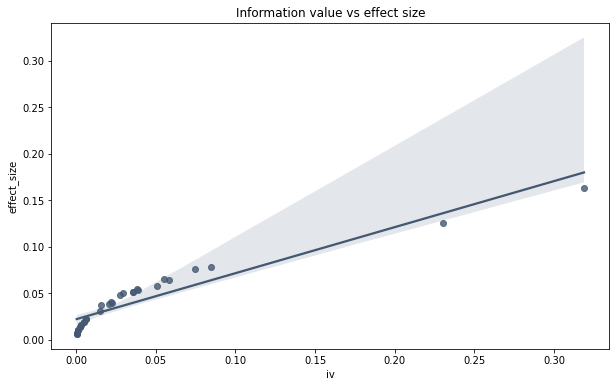

Pearson correlation: 0.94
Spearman correlation: 1.00


In [20]:
df_analysis_sign = df_analysis[df_analysis['p-value']<0.05]

fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x='iv', y='effect_size', data=df_analysis_sign, color='#455872')
ax.set_title('Information value vs effect size')
plt.show()

print('Pearson correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size']))
print('Spearman correlation: %0.2f' % df_analysis_sign['iv'].corr(df_analysis_sign['effect_size'], method='spearman'))

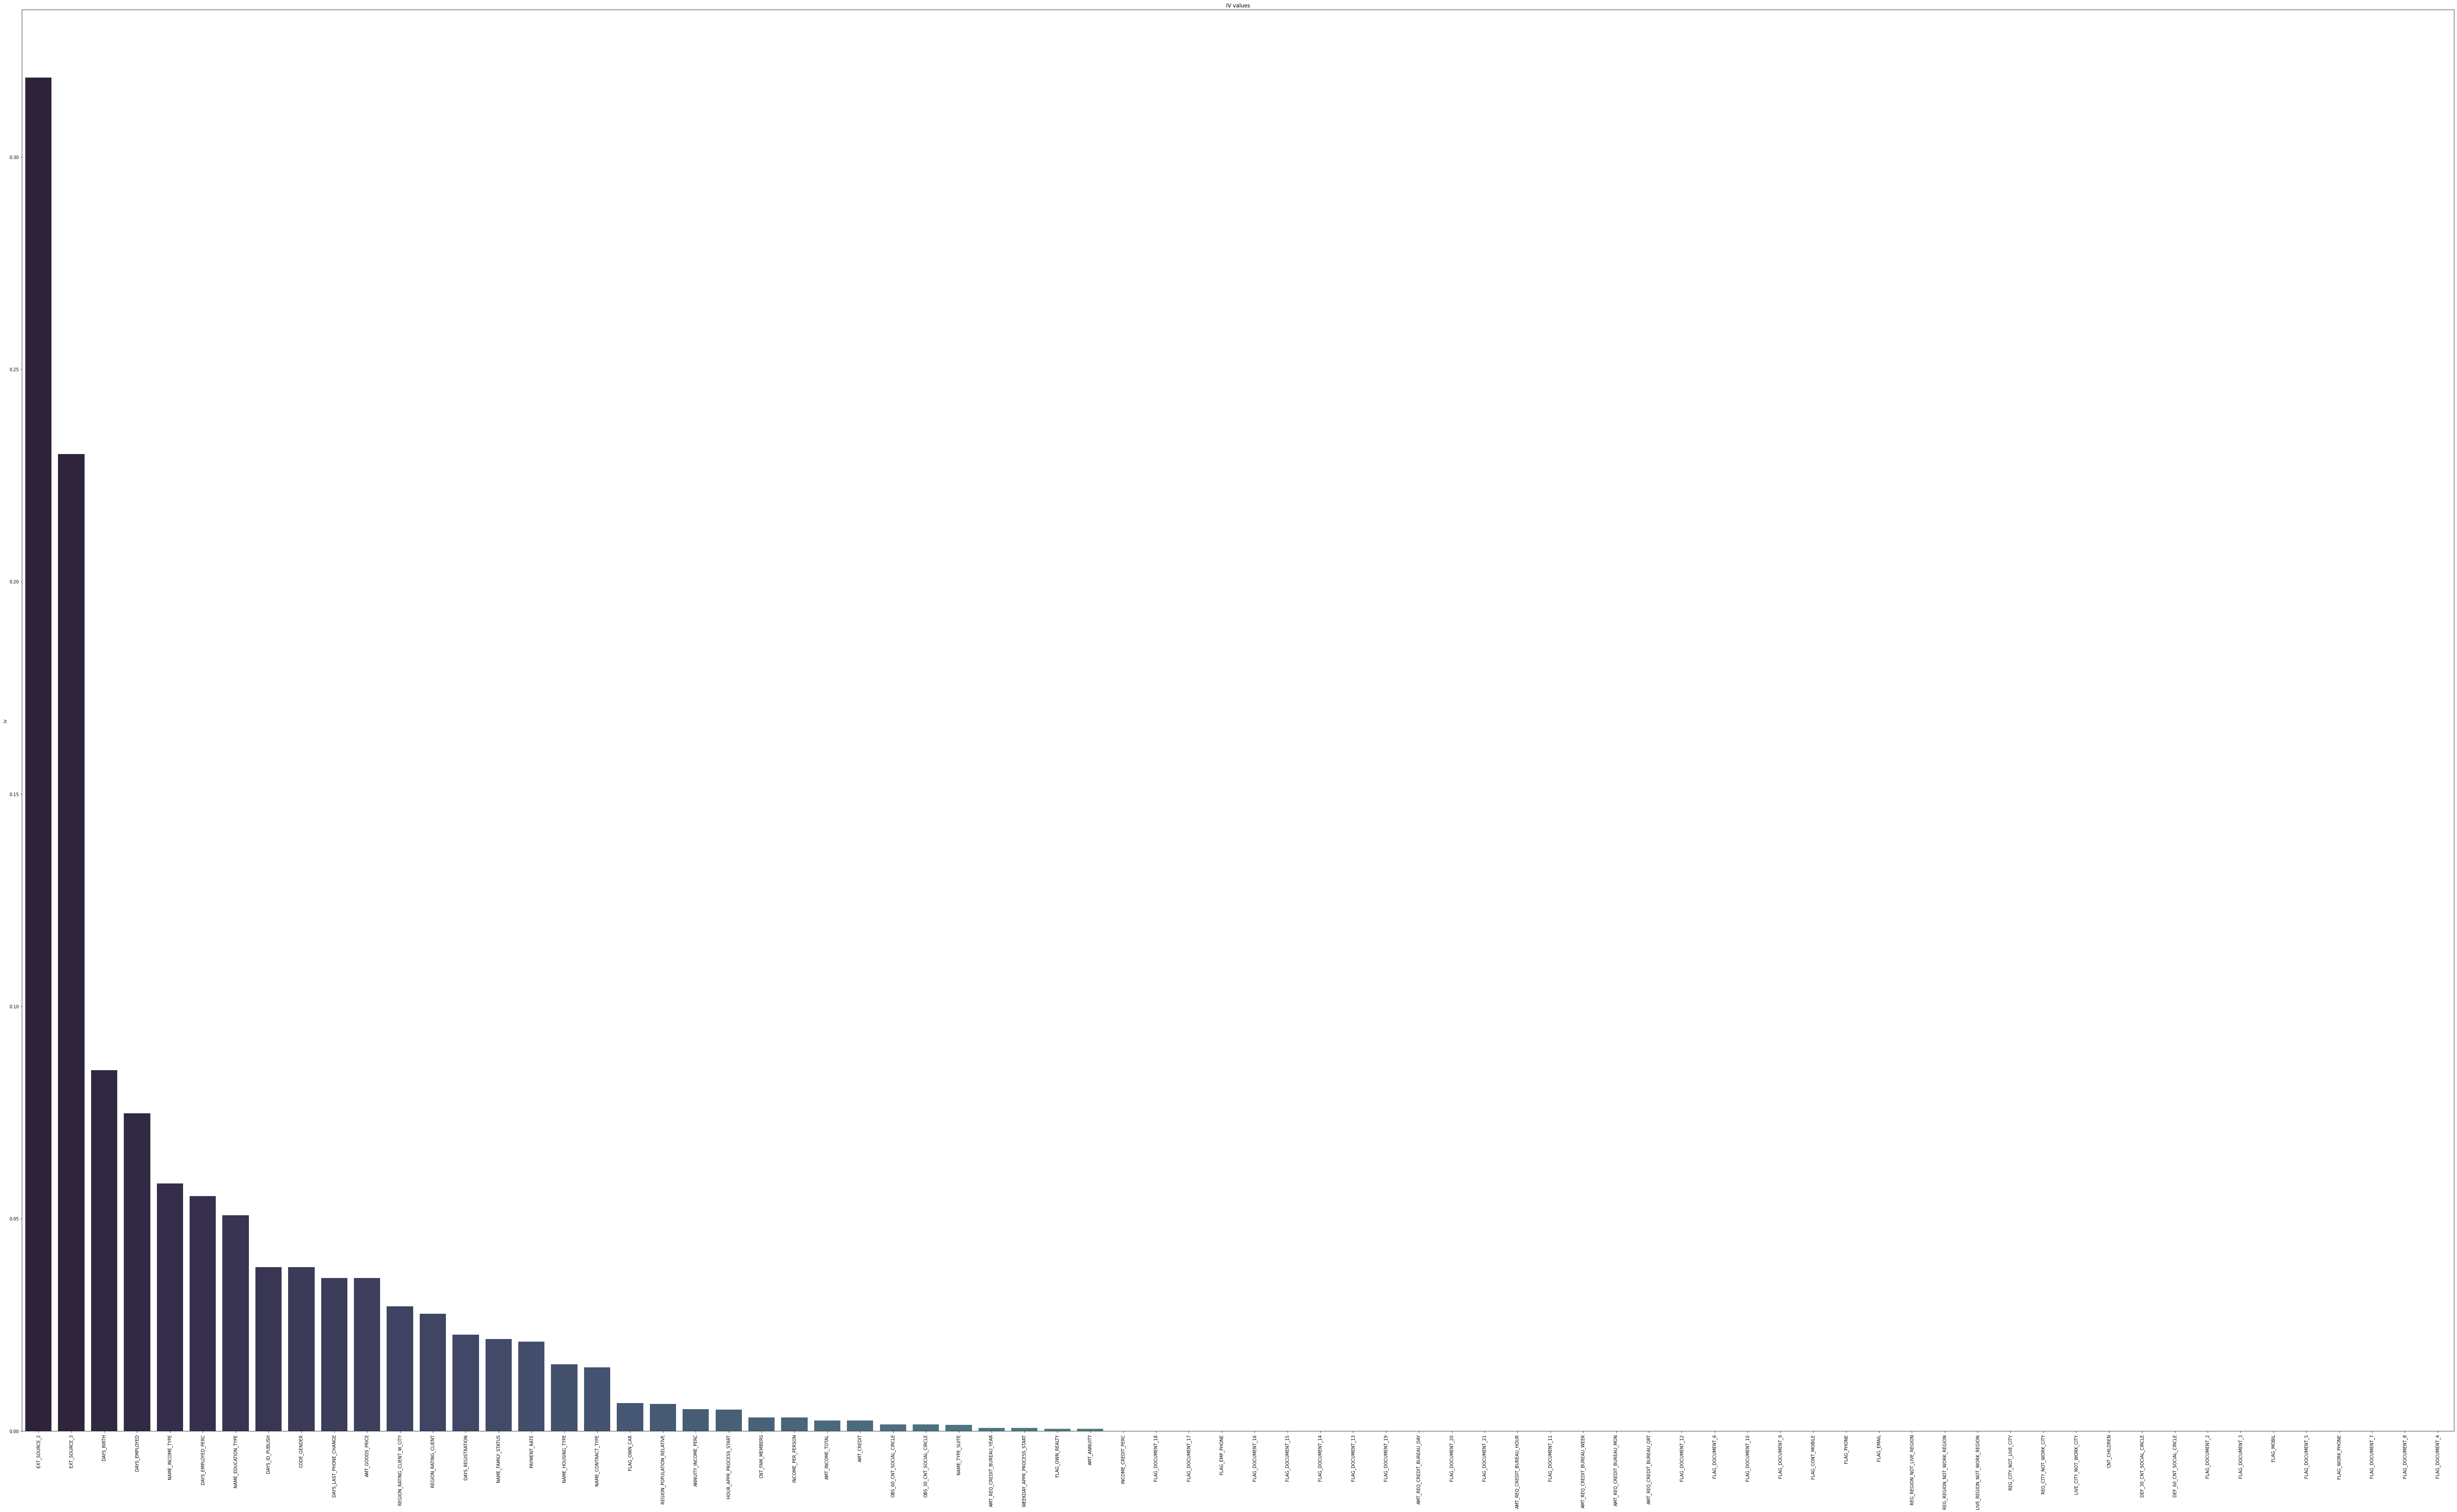

In [21]:
ar.draw_iv(feats, iv)

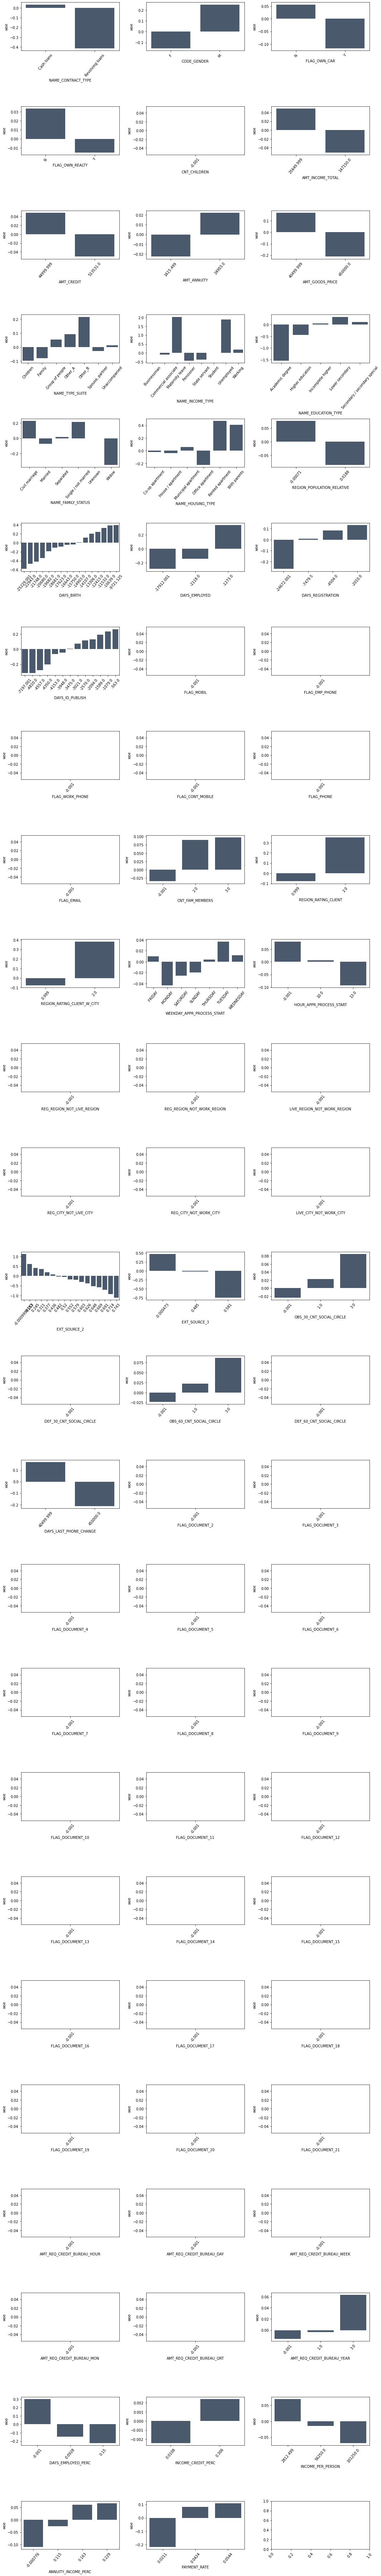

In [22]:
ar.draw_woe_multiplot(feats,iv)

In [23]:
#select fitur
feature_keep = df_analysis[df_analysis["iv"] > 0.02].index
feature_keep

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'NAME_INCOME_TYPE', 'DAYS_EMPLOYED_PERC', 'NAME_EDUCATION_TYPE',
       'DAYS_ID_PUBLISH', 'CODE_GENDER', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_REGISTRATION', 'NAME_FAMILY_STATUS',
       'PAYMENT_RATE'],
      dtype='object')

In [24]:
#for splitting
df_feat = df[feature_keep]
df_feat.shape

(307507, 16)

In [25]:
df_feat.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,NAME_INCOME_TYPE,DAYS_EMPLOYED_PERC,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_REGISTRATION,NAME_FAMILY_STATUS,PAYMENT_RATE
0,0.262949,0.139376,-9461,-637.0,Working,0.067329,Secondary / secondary special,-2120,M,351000.0,351000.0,2,2,-3648.0,Single / not married,0.060749
1,0.622246,0.535276,-16765,-1188.0,State servant,0.070862,Higher education,-291,F,1129500.0,1129500.0,1,1,-1186.0,Married,0.027598
2,0.555912,0.729567,-19046,-225.0,Working,0.011814,Secondary / secondary special,-2531,M,135000.0,135000.0,2,2,-4260.0,Single / not married,0.050000
3,0.650442,0.535276,-19005,-3039.0,Working,0.159905,Secondary / secondary special,-2437,F,297000.0,297000.0,2,2,-9833.0,Civil marriage,0.094941
4,0.322738,0.535276,-19932,-3038.0,Working,0.152418,Secondary / secondary special,-3458,M,513000.0,513000.0,2,2,-4311.0,Single / not married,0.042623


In [26]:
df_concat = pd.concat([df_feat, df['TARGET']], axis = 1)
df_concat.reset_index(drop=True)
df_concat.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,NAME_INCOME_TYPE,DAYS_EMPLOYED_PERC,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,AMT_GOODS_PRICE,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_REGISTRATION,NAME_FAMILY_STATUS,PAYMENT_RATE,TARGET
0,0.262949,0.139376,-9461,-637.0,Working,0.067329,Secondary / secondary special,-2120,M,351000.0,351000.0,2,2,-3648.0,Single / not married,0.060749,1
1,0.622246,0.535276,-16765,-1188.0,State servant,0.070862,Higher education,-291,F,1129500.0,1129500.0,1,1,-1186.0,Married,0.027598,0
2,0.555912,0.729567,-19046,-225.0,Working,0.011814,Secondary / secondary special,-2531,M,135000.0,135000.0,2,2,-4260.0,Single / not married,0.050000,0
3,0.650442,0.535276,-19005,-3039.0,Working,0.159905,Secondary / secondary special,-2437,F,297000.0,297000.0,2,2,-9833.0,Civil marriage,0.094941,0
4,0.322738,0.535276,-19932,-3038.0,Working,0.152418,Secondary / secondary special,-3458,M,513000.0,513000.0,2,2,-4311.0,Single / not married,0.042623,0


# Correlation and Association Matrix

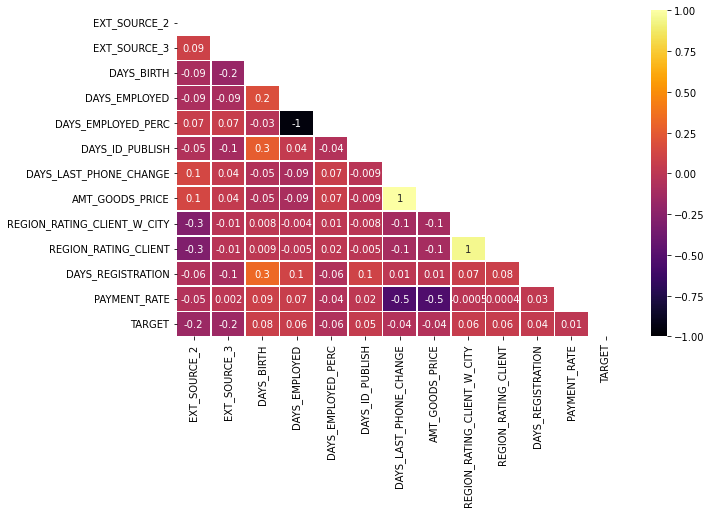

In [27]:
# correlation matrix with correlation co-effiecients 
mask = np.zeros_like(df_concat.corr().fillna(0), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,6))
sns.heatmap(df_concat.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

In [28]:
df_concat.drop(columns=['AMT_GOODS_PRICE','REGION_RATING_CLIENT','DAYS_EMPLOYED_PERC'], inplace=True)

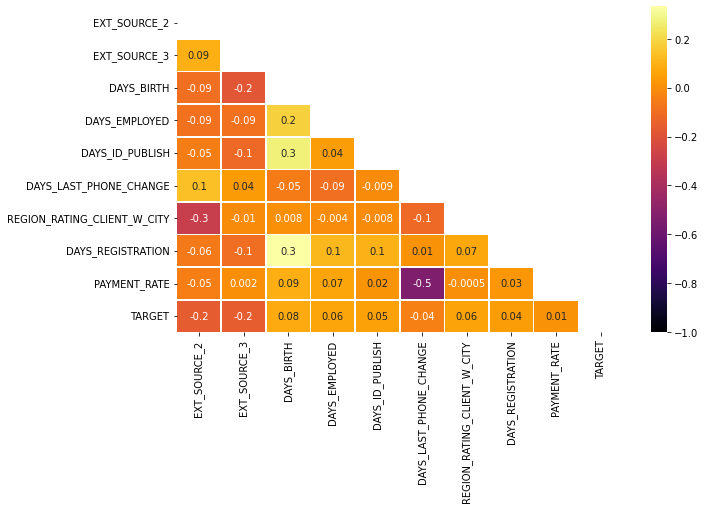

In [29]:
# correlation matrix with correlation co-effiecients 
mask = np.zeros_like(df_concat.corr().fillna(0), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,6))
sns.heatmap(df_concat.corr(), mask=mask, annot=True,  cmap="inferno", vmin = -1, fmt='.1g', edgecolor='w', linewidth=0.6)

# Check Outliers and Distribution features

In [30]:
df_target = df_concat.copy()
df_target = df_concat.drop(['TARGET'],axis=1)

In [31]:
df_obj= df_target.select_dtypes(exclude = 'number')
df_num = df_target.select_dtypes(include = 'number')

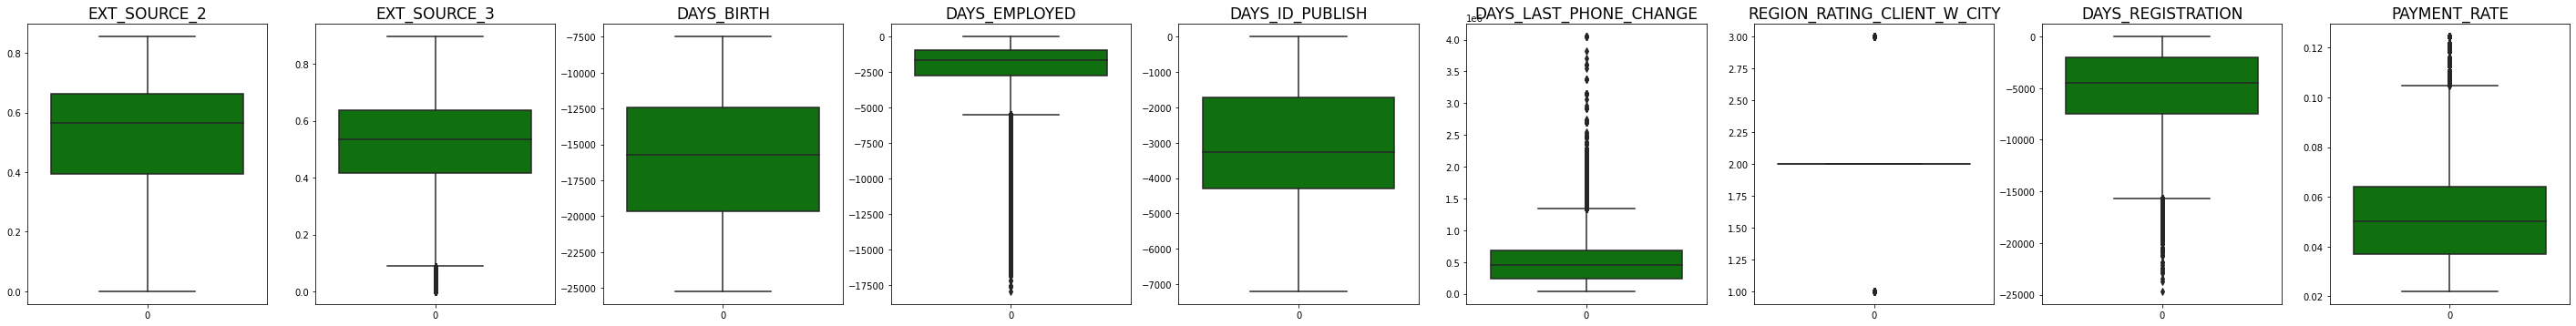

In [32]:
cols = list(df_num.columns.values)

plt.figure(figsize=(50, 60))
for n, col in enumerate(cols):
  plt.subplot(9,9,n+1)
  sns.boxplot(data = df_num[col], color = 'green')
  plt.title(col, fontsize=17)
plt.show()

- seperti yang terlihat feature - feature numeric beberapa ada yang memiliki outlier, dan nantinya akan saya treat denga nilai mediannya, sebenarnya banyak cara untuk penanganannya. tapi saya ambil cara yang paling banyak digunakan orang yaitu di treat dengan nilai median.

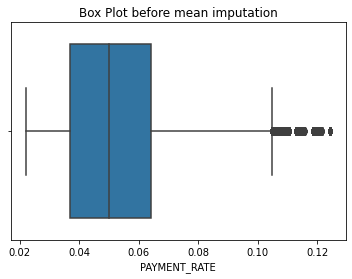

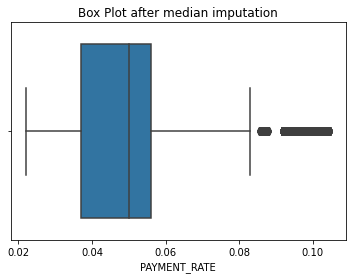

In [33]:
sns.boxplot(df_target['PAYMENT_RATE'])
plt.title("Box Plot before mean imputation")
plt.show()

q1 = df_target['PAYMENT_RATE'].quantile(0.25)
q3 = df_target['PAYMENT_RATE'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df_target['PAYMENT_RATE'])
for i in df_target['PAYMENT_RATE']:
    if i > Upper_tail or i < Lower_tail:
            df_target['PAYMENT_RATE']= df_target['PAYMENT_RATE'].replace(i, m)

sns.boxplot(df_target['PAYMENT_RATE'])
plt.title("Box Plot after median imputation")
plt.show()   

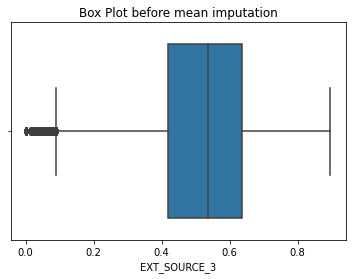

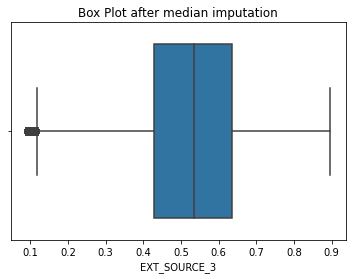

In [34]:
sns.boxplot(df_target['EXT_SOURCE_3'])
plt.title("Box Plot before mean imputation")
plt.show()

q1 = df_target['EXT_SOURCE_3'].quantile(0.25)
q3 = df_target['EXT_SOURCE_3'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df_target['EXT_SOURCE_3'])
for i in df_target['EXT_SOURCE_3']:
    if i > Upper_tail or i < Lower_tail:
            df_target['EXT_SOURCE_3']= df_target['EXT_SOURCE_3'].replace(i, m)

sns.boxplot(df_target['EXT_SOURCE_3'])
plt.title("Box Plot after median imputation")
plt.show()   

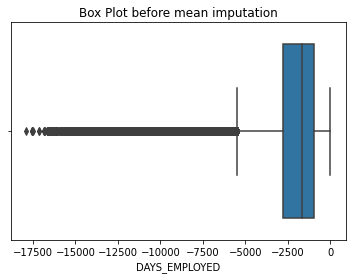

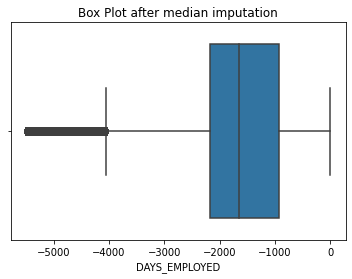

In [35]:
sns.boxplot(df_target['DAYS_EMPLOYED'])
plt.title("Box Plot before mean imputation")
plt.show()

q1 = df_target['DAYS_EMPLOYED'].quantile(0.25)
q3 = df_target['DAYS_EMPLOYED'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df_target['DAYS_EMPLOYED'])
for i in df_target['DAYS_EMPLOYED']:
    if i > Upper_tail or i < Lower_tail:
            df_target['DAYS_EMPLOYED']= df_target['DAYS_EMPLOYED'].replace(i, m)

sns.boxplot(df_target['DAYS_EMPLOYED'])
plt.title("Box Plot after median imputation")
plt.show()   

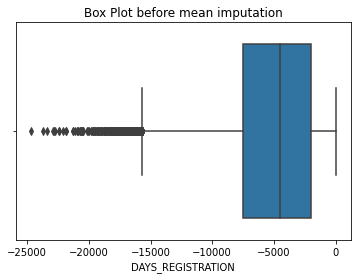

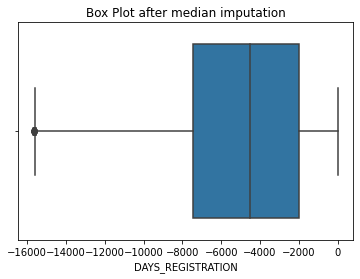

In [36]:
sns.boxplot(df_target['DAYS_REGISTRATION'])
plt.title("Box Plot before mean imputation")
plt.show()

q1 = df_target['DAYS_REGISTRATION'].quantile(0.25)
q3 = df_target['DAYS_REGISTRATION'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df_target['DAYS_REGISTRATION'])
for i in df_target['DAYS_REGISTRATION']:
    if i > Upper_tail or i < Lower_tail:
            df_target['DAYS_REGISTRATION']= df_target['DAYS_REGISTRATION'].replace(i, m)

sns.boxplot(df_target['DAYS_REGISTRATION'])
plt.title("Box Plot after median imputation")
plt.show()   

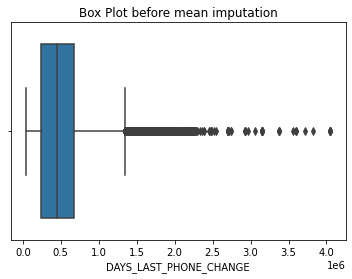

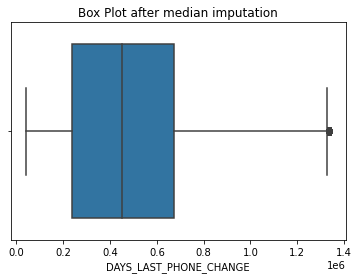

In [37]:
sns.boxplot(df_target['DAYS_LAST_PHONE_CHANGE'])
plt.title("Box Plot before mean imputation")
plt.show()

q1 = df_target['DAYS_LAST_PHONE_CHANGE'].quantile(0.25)
q3 = df_target['DAYS_LAST_PHONE_CHANGE'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
m = np.median(df_target['DAYS_LAST_PHONE_CHANGE'])
for i in df_target['DAYS_LAST_PHONE_CHANGE']:
    if i > Upper_tail or i < Lower_tail:
            df_target['DAYS_LAST_PHONE_CHANGE']= df_target['DAYS_LAST_PHONE_CHANGE'].replace(i, m)

sns.boxplot(df_target['DAYS_LAST_PHONE_CHANGE'])
plt.title("Box Plot after median imputation")
plt.show()   

In [38]:
df_num2 = df_target.select_dtypes(include = 'number')

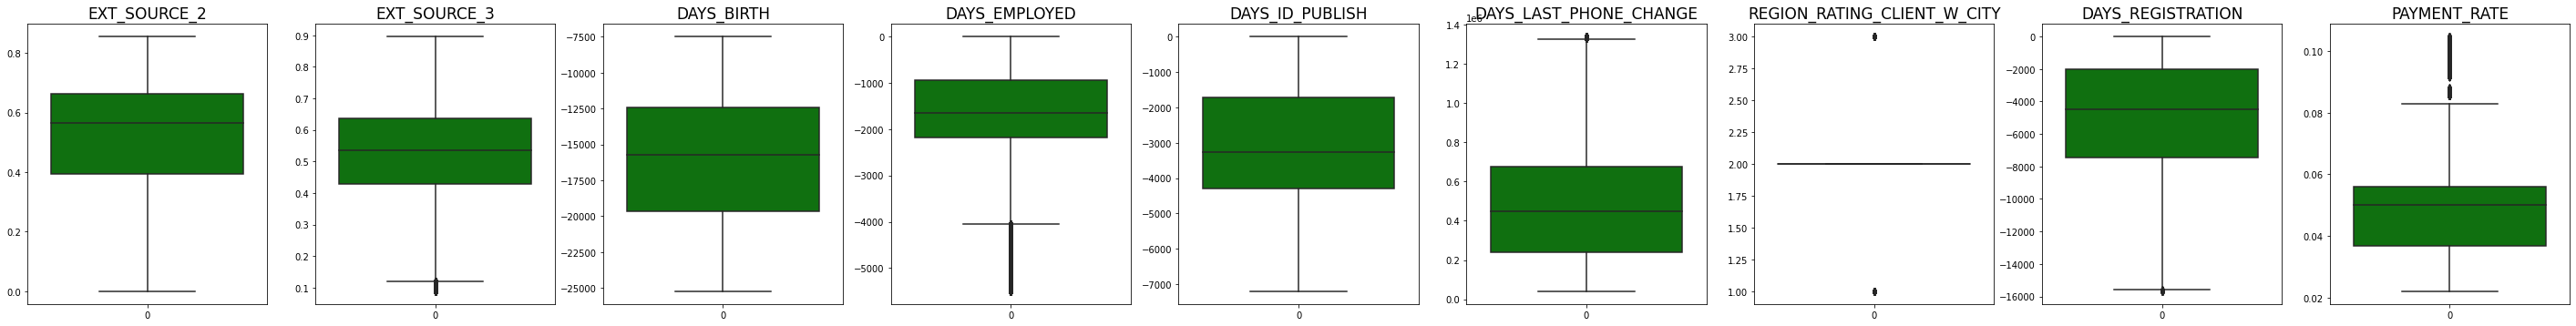

In [39]:
cols = list(df_num2.columns.values)

plt.figure(figsize=(50, 60))
for n, col in enumerate(cols):
  plt.subplot(9,9,n+1)
  sns.boxplot(data = df_num2[col], color = 'green')
  plt.title(col, fontsize=17)
plt.show()

In [40]:
df_concat = pd.concat([df_target, df['TARGET']], axis = 1)
df_concat.reset_index(drop=True)
df_concat.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,DAYS_ID_PUBLISH,CODE_GENDER,DAYS_LAST_PHONE_CHANGE,REGION_RATING_CLIENT_W_CITY,DAYS_REGISTRATION,NAME_FAMILY_STATUS,PAYMENT_RATE,TARGET
0,0.262949,0.139376,-9461,-637.0,Working,Secondary / secondary special,-2120,M,351000.0,2,-3648.0,Single / not married,0.060749,1
1,0.622246,0.535276,-16765,-1188.0,State servant,Higher education,-291,F,1129500.0,1,-1186.0,Married,0.027598,0
2,0.555912,0.729567,-19046,-225.0,Working,Secondary / secondary special,-2531,M,135000.0,2,-4260.0,Single / not married,0.050000,0
3,0.650442,0.535276,-19005,-3039.0,Working,Secondary / secondary special,-2437,F,297000.0,2,-9833.0,Civil marriage,0.094941,0
4,0.322738,0.535276,-19932,-3038.0,Working,Secondary / secondary special,-3458,M,513000.0,2,-4311.0,Single / not married,0.042623,0


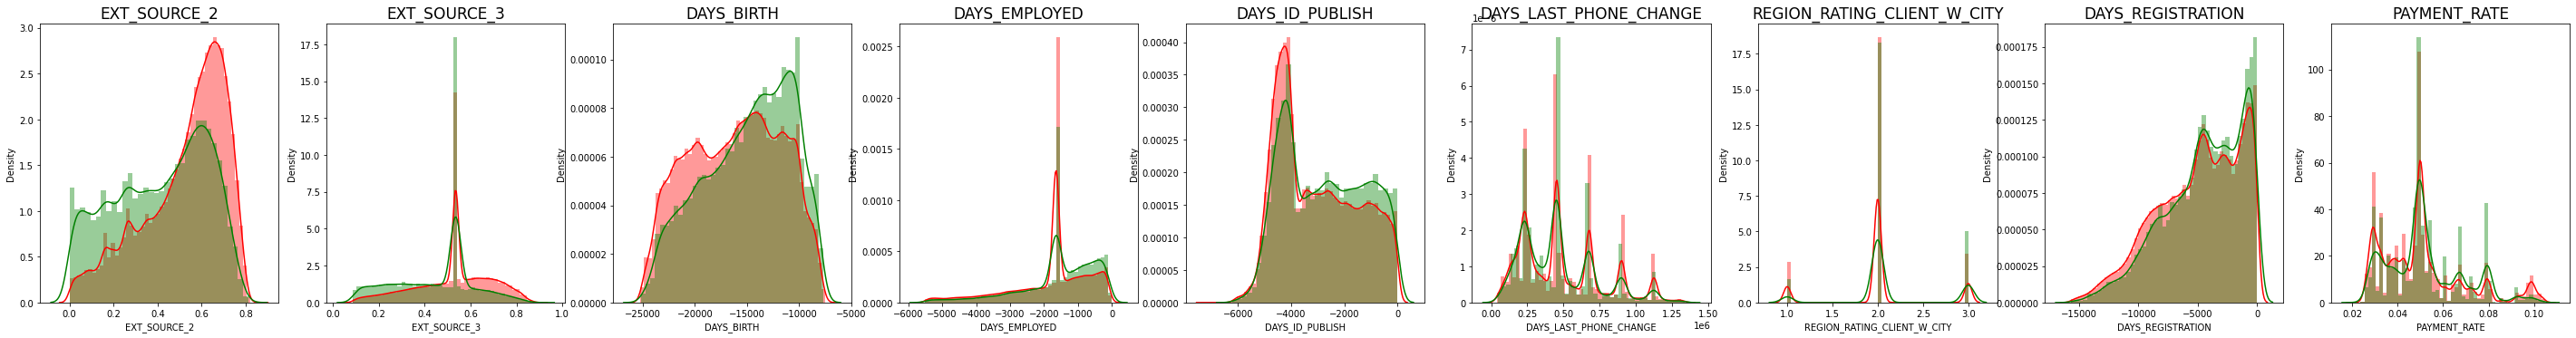

In [41]:
bad_status = df.TARGET == 0
good_status = df.TARGET == 1

cols = list(df_num2.columns.values)

plt.figure(figsize=(50, 60))
for n, col in enumerate(cols):
  plt.subplot(9,9,n+1)
  sns.distplot(df_num2[col][bad_status], color='red')
  sns.distplot(df_num2[col][good_status], color='green')
  plt.title(col, fontsize=17)
plt.show()

In [42]:
def woebin_plot_new(bins, x=None, title=None, show_iv=True):
    
    xs = x
    # bins concat 
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    # good bad distr
    def gb_distr(binx):
        binx['good_distr'] = binx['good']/sum(binx['count'])
        binx['bad_distr'] = binx['bad']/sum(binx['count'])
        return binx
    bins = bins.groupby('variable').apply(gb_distr)
    # x variable names
    if xs is None: xs = bins['variable'].unique()
    # plot export
    plotlist = {}
    for i in xs:
        binx = bins[bins['variable'] == i].reset_index()
        plotlist[i] = plot_bin_new(binx, title, show_iv)
    return plotlist

In [43]:
def plot_bin_new(binx, title, show_iv):
  
    # y_right_max
    y_right_max = np.ceil(binx['badprob'].max()*10)
    if y_right_max % 2 == 1: y_right_max=y_right_max+1
    if y_right_max - binx['badprob'].max()*10 <= 0.3: y_right_max = y_right_max+2
    y_right_max = y_right_max/10
    if y_right_max>1 or y_right_max<=0 or y_right_max is np.nan or y_right_max is None: y_right_max=1
    ## y_left_max
    y_left_max = np.ceil(binx['count_distr'].max()*10)/10
    if y_left_max>1 or y_left_max<=0 or y_left_max is np.nan or y_left_max is None: y_left_max=1
    # title
    title_string = binx.loc[0,'variable']+"  (iv:"+str(round(binx.loc[0,'total_iv'],4))+")" if show_iv else binx.loc[0,'variable']
    title_string = title+'-'+title_string if title is not None else title_string
    # param
    ind = np.arange(len(binx.index))    # the x locations for the groups
    width = 0.5       # the width of the bars: can also be len(x) sequence
    ###### plot ###### 
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax2 = ax1.twinx()
    # ax1
    p1 = ax1.bar(ind, binx['good_distr'], width, color=(24/254, 192/254, 196/254))
    p2 = ax1.bar(ind, binx['bad_distr'], width, bottom=binx['good_distr'], color=(246/254, 115/254, 109/254))
    for i in ind:
        ax1.text(i, binx.loc[i,'count_distr']*1.02, str(round(binx.loc[i,'count_distr']*100,1))+'%, '+str(binx.loc[i,'count']), ha='center')
    # ax2
    ax2.plot(ind, binx['badprob'], marker='o', color='blue')
    for i in ind:
        ax2.text(i, binx.loc[i,'badprob']*1.02, str(round(binx.loc[i,'badprob'], 2)) , color='blue', ha='center')
    # settings
    ax1.set_ylabel('Bin count distribution')
    ax2.set_ylabel('Bad Probability', color='blue')
    ax1.set_yticks(np.arange(0, y_left_max+0.2, 0.2))
    ax2.set_yticks(np.arange(0, y_right_max+0.2, 0.2))
    ax2.tick_params(axis='y', colors='blue')
    ax1.tick_params(axis='x', rotation=45)
    plt.xticks(ind, binx['bin'])
#     plt.xticks(rotation = 45)
#     plt.figure(figsize=(12,6))
    plt.rcParams['font.size'] = '14'
    plt.title(title_string, loc='left')
    plt.legend((p2[0], p1[0]), ('bad', 'good'), loc='upper right')
    # show plot 
    # plt.show()
    return fig

In [44]:
#making binning 
bins = sc.woebin(df_concat,y=["TARGET"],monotonic_trend="auto_asc_desc")

[INFO] creating woe binning ...
Binning on 307507 rows and 14 columns in 00:00:27


{'DAYS_ID_PUBLISH': <Figure size 864x432 with 2 Axes>,
 'DAYS_BIRTH': <Figure size 864x432 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 864x432 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 864x432 with 2 Axes>,
 'CODE_GENDER': <Figure size 864x432 with 2 Axes>,
 'NAME_INCOME_TYPE': <Figure size 864x432 with 2 Axes>,
 'EXT_SOURCE_3': <Figure size 864x432 with 2 Axes>,
 'DAYS_EMPLOYED': <Figure size 864x432 with 2 Axes>,
 'PAYMENT_RATE': <Figure size 864x432 with 2 Axes>,
 'NAME_FAMILY_STATUS': <Figure size 864x432 with 2 Axes>,
 'EXT_SOURCE_2': <Figure size 864x432 with 2 Axes>,
 'REGION_RATING_CLIENT_W_CITY': <Figure size 864x432 with 2 Axes>,
 'DAYS_REGISTRATION': <Figure size 864x432 with 2 Axes>}

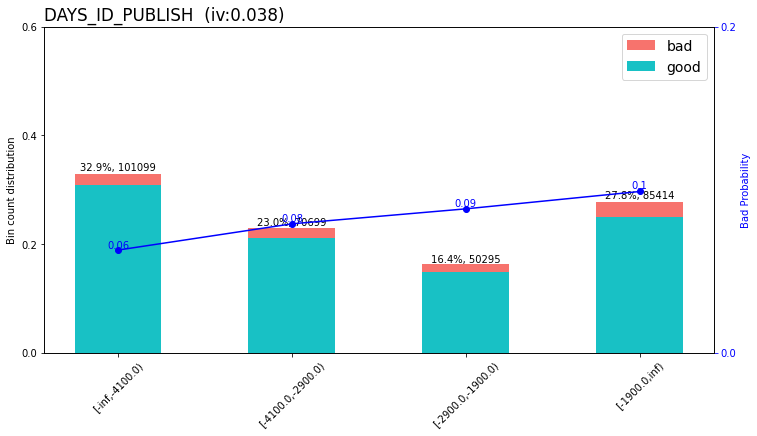

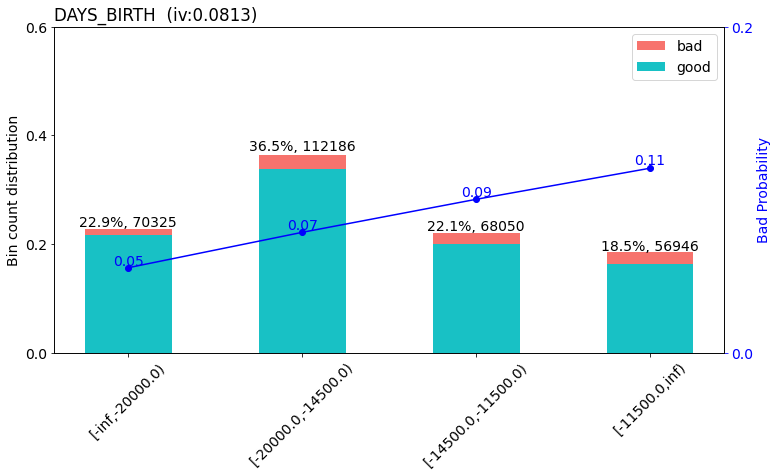

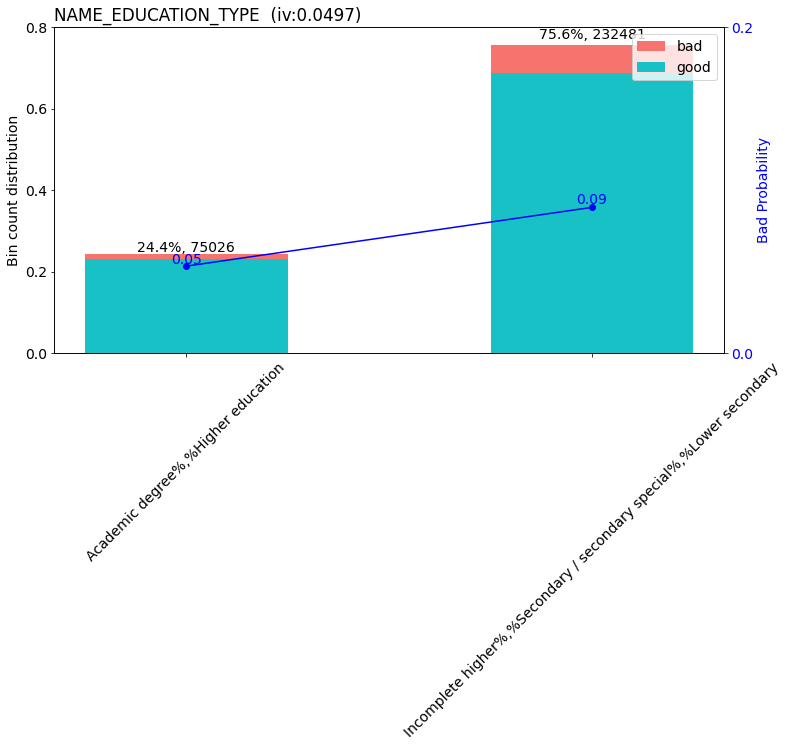

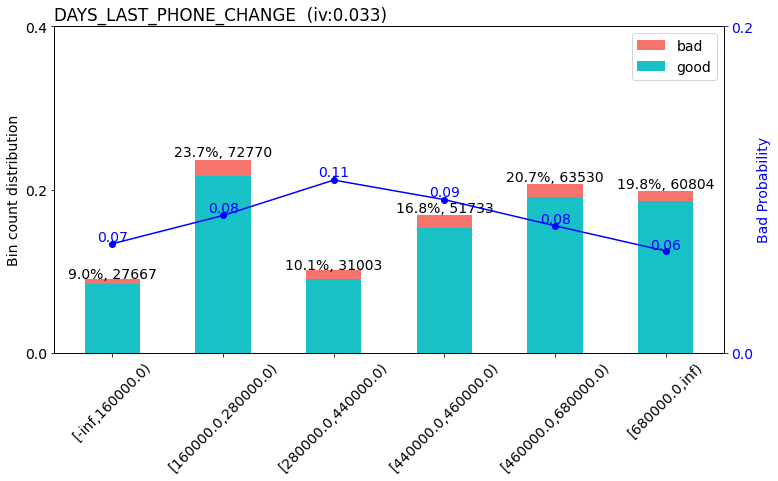

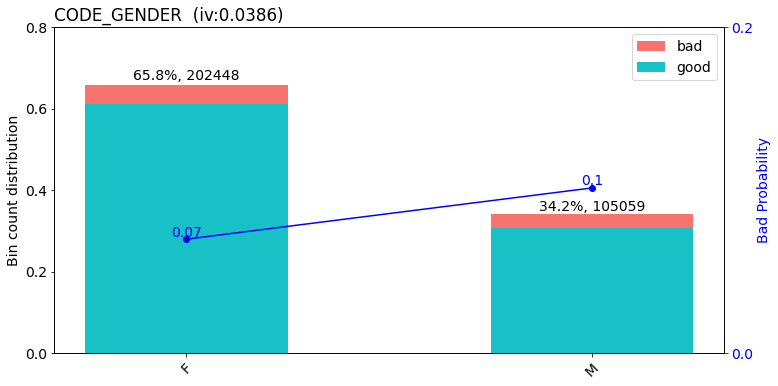

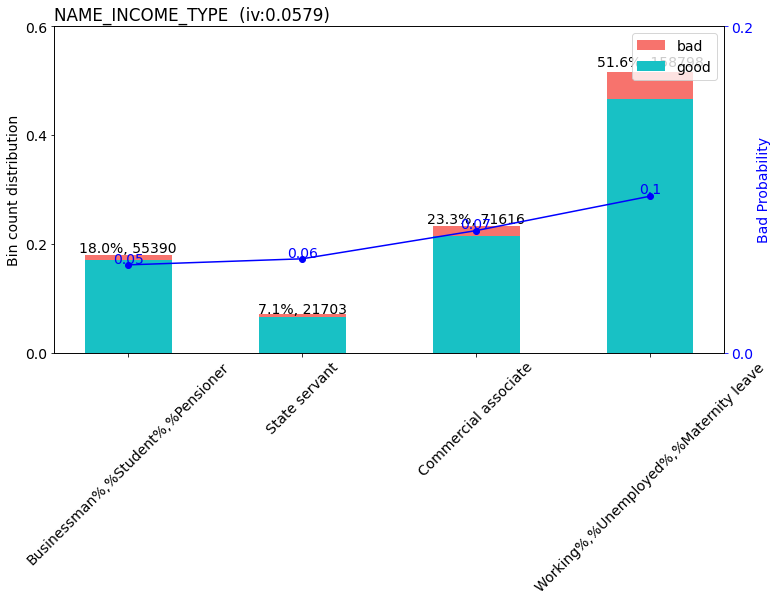

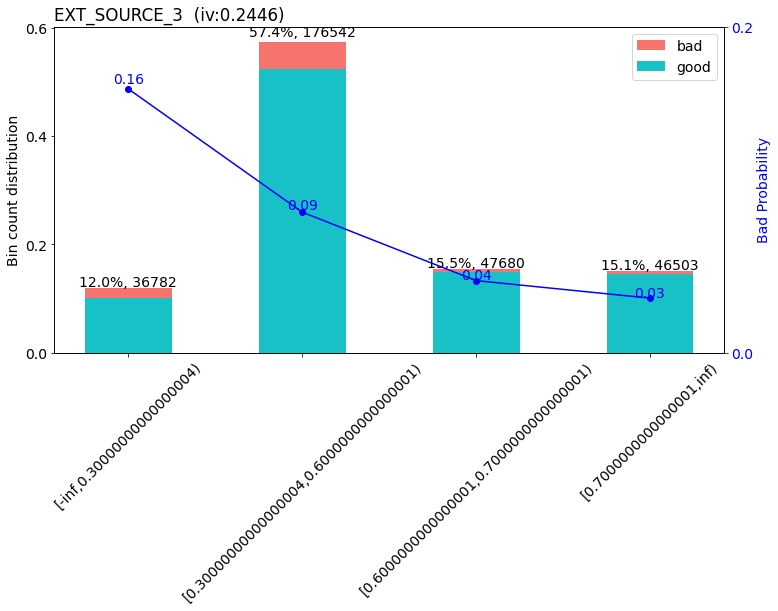

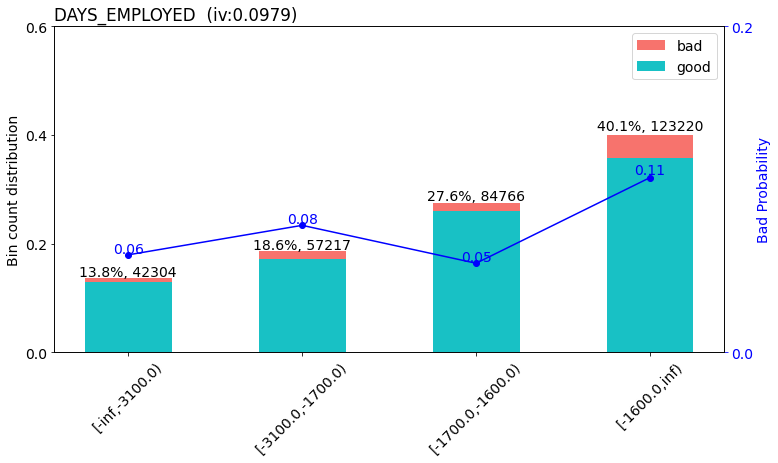

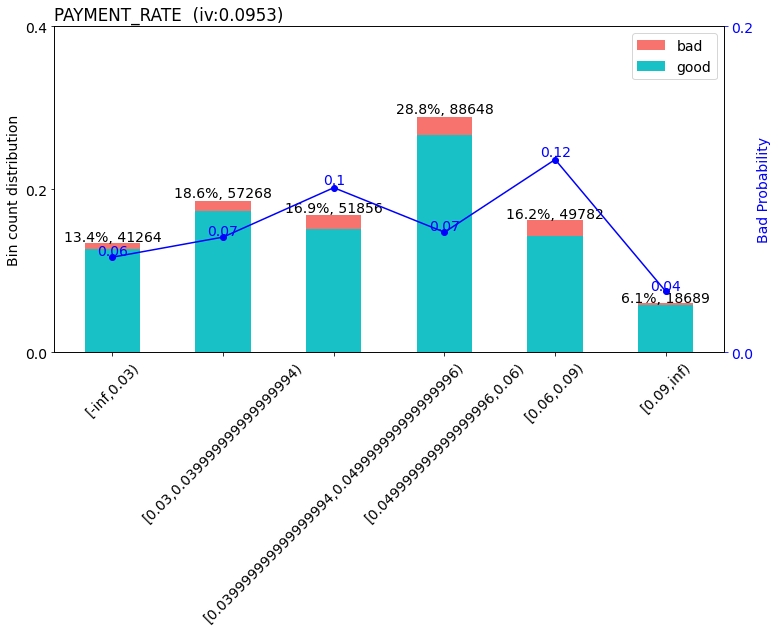

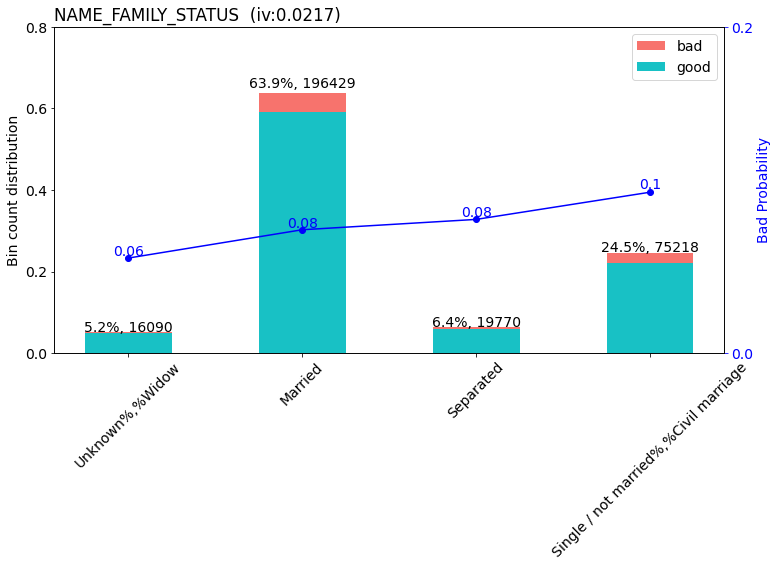

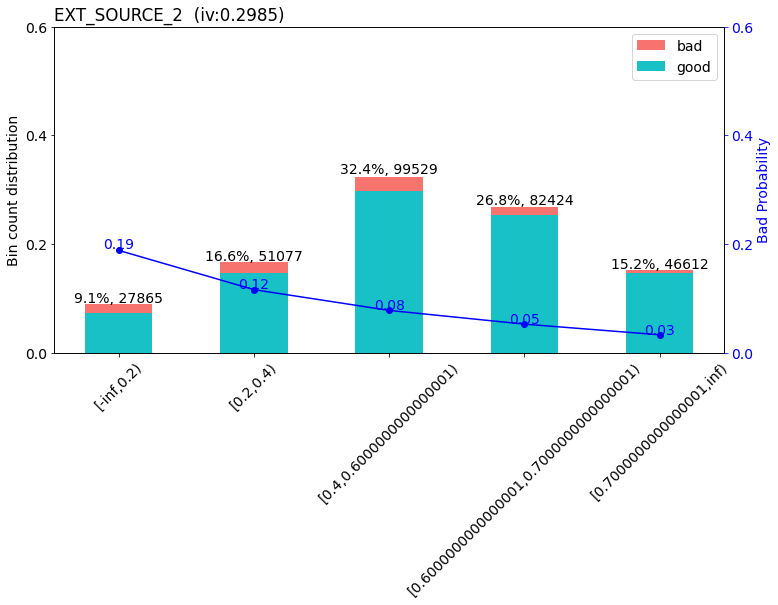

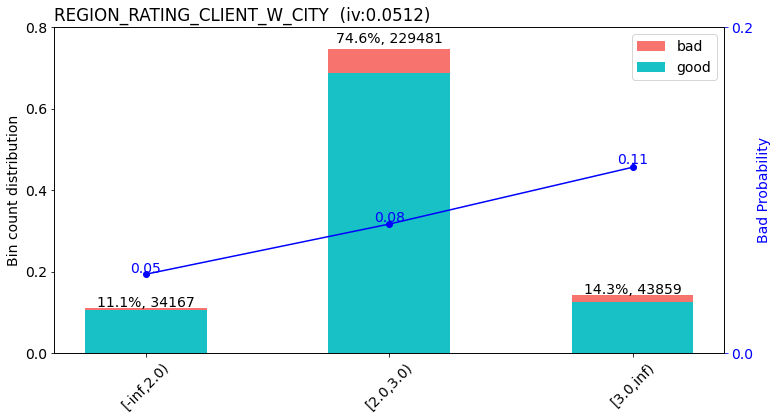

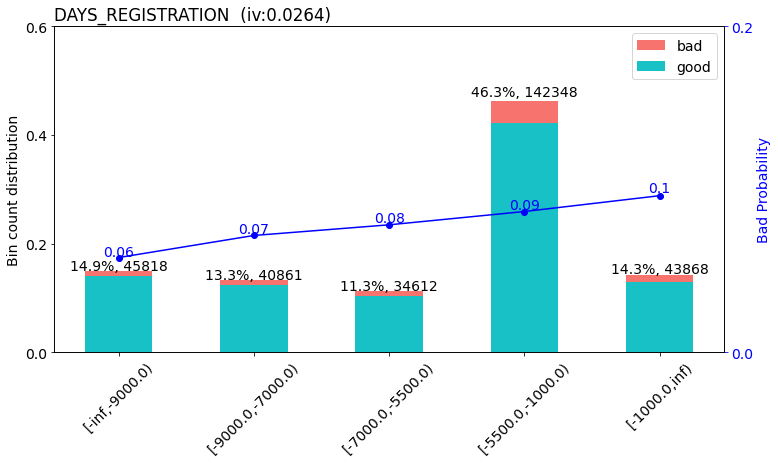

In [45]:
woebin_plot_new(bins)

Analysis Report : <br>
1.EXT_SCORE_2 : semakin besar EXT_SCORE_2,maka persentase **good borrower** semakin besar. <br>
2.EXT_SCORE_3 : persentase **good borrower**  terlihat semakin besar pada EXT_SCORE_3 bila juga semakin besar.  <br>
3.DAYS_BIRTH : probabilitas persentase **good borrower** terlihat semakin besar, ketika umur orang tersebut semakin muda dibanding yang tua. asumsi saya ini mungin terjadi, karna sudah memasuki masa pensiun jadi nasabah dengan umur tua mungkin akan mengurangi tanggungan yang harus dia bayar. <br>
4.DAYS_EMPLOYED : persentase **good borrower** terlihat semakin besar, ketika pengalaman kerjanya semakin lama.<br>
5.PAYMENT_RATE : persentase **good borrower** pada PAYMENT_RATE semakin besar, bila persentase PAYMENT_RATE semakin kecil.

# EDA based on WOE-IV and scorecard

In [47]:
data_num = df_concat.select_dtypes(include = 'number')
data_obj = df_concat.select_dtypes(exclude = 'number')
data_obj.head()

,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,CODE_GENDER,NAME_FAMILY_STATUS
0,Working,Secondary / secondary special,M,Single / not married
1,State servant,Higher education,F,Married
2,Working,Secondary / secondary special,M,Single / not married
3,Working,Secondary / secondary special,F,Civil marriage
4,Working,Secondary / secondary special,M,Single / not married


Text(0.5, 1.0, 'Count INCOME_TYPE')

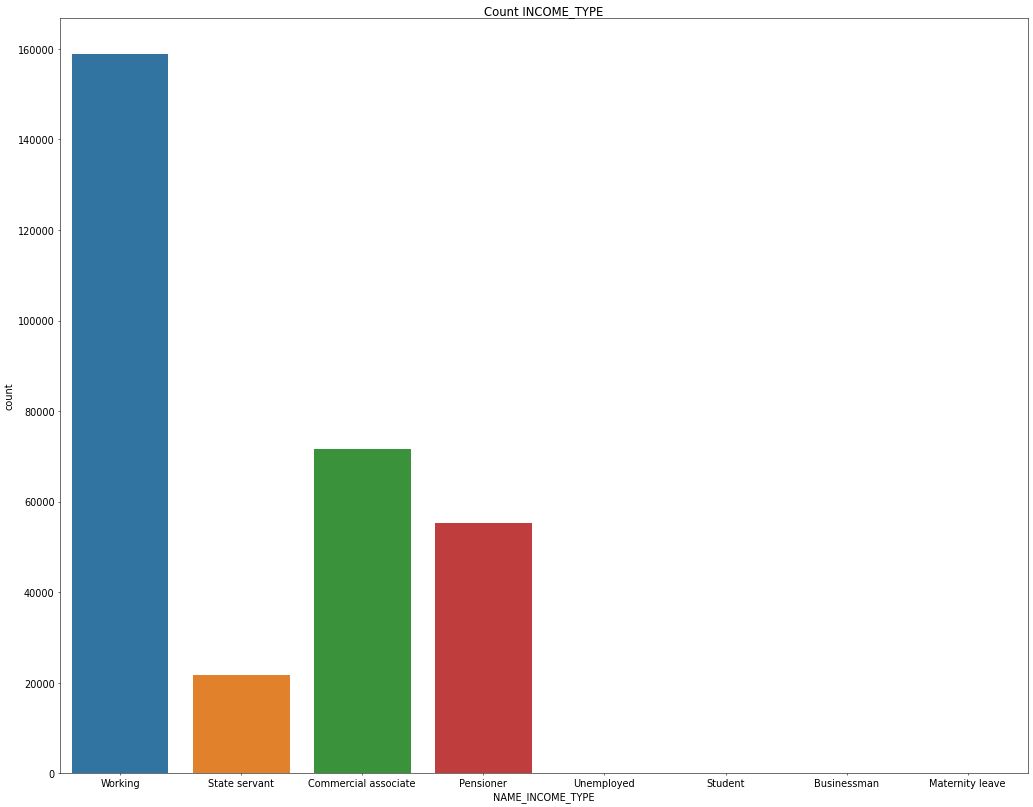

In [48]:
plt.figure(figsize=(25,20),dpi=50)
sns.countplot(data=df_concat,x='NAME_INCOME_TYPE')
plt.title("Count INCOME_TYPE")

**borrower** kebanyakan berasal dari golongan **working** 

Text(0.5, 1.0, 'Count EDUCATION')

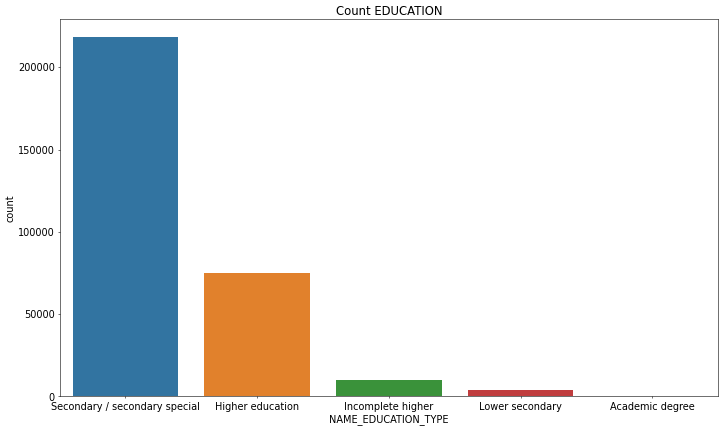

In [49]:
plt.figure(figsize=(17,10),dpi=50)
sns.countplot(data=df_concat,x='NAME_EDUCATION_TYPE')
plt.title("Count EDUCATION")

**borrower** kebanyakn berasal dari golongan pendidikan **secondary/ secondary Special**

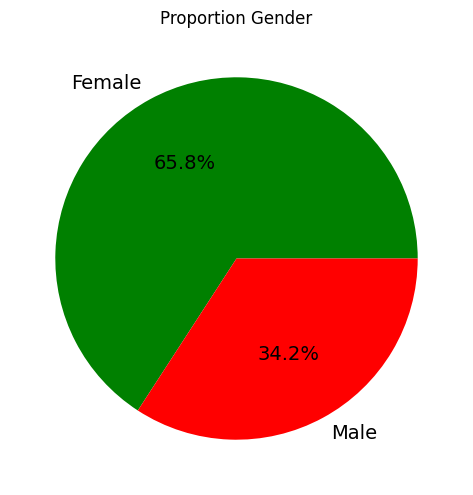

In [50]:
plt.figure(figsize=(8,6),dpi=100)
plt.title("Proportion Gender",fontsize=12)
plt.pie(df_concat["CODE_GENDER"].value_counts(),labels=["Female","Male"],
       autopct='%1.1f%%',colors=["g","r"]);

**borrower** kebanyakan memiliki gender female.

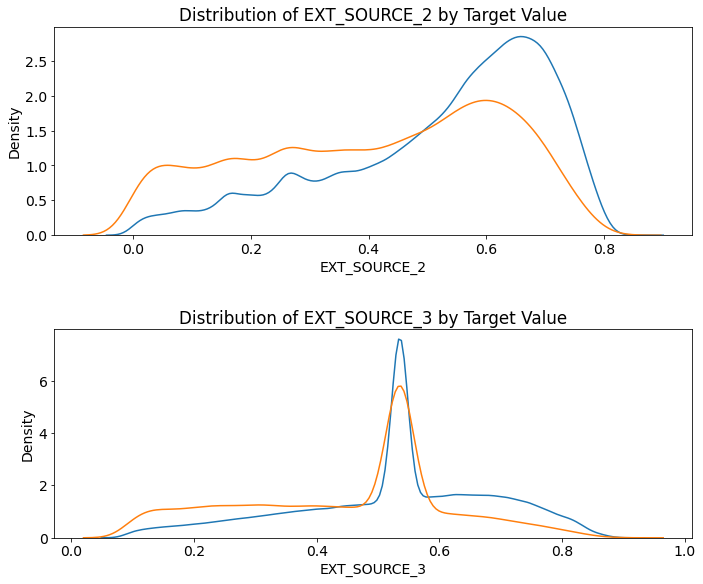

In [51]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df_concat.loc[df_concat['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df_concat.loc[df_concat['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source) 
    plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

Text(0.5, 1.0, 'Count FAMILY STATUS')

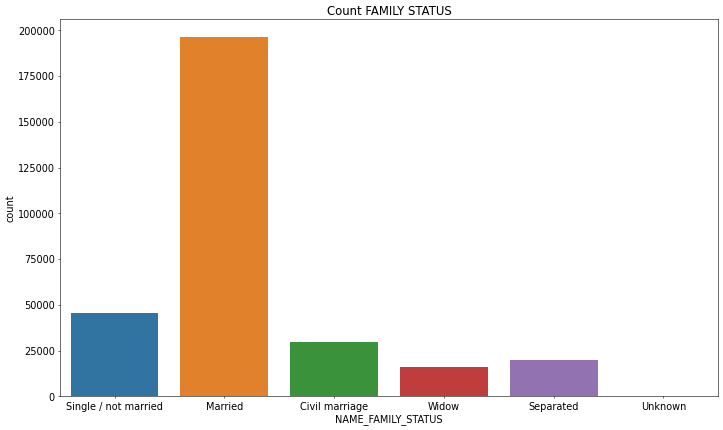

In [52]:
plt.figure(figsize=(17,10),dpi=50)
sns.countplot(data=df_concat,x='NAME_FAMILY_STATUS')
plt.title("Count FAMILY STATUS")

**borrower** kebanyakan berstatus **married** <br><br><br>

Exploratory data analysis Report : <br> <br>
dari hasil simple EDA diatas, untuk **short term** plan. target produk kreditnya bisa diarahkan khusus :
**Wanita**, dengan status **Married**, dengan status pekerjaan **working**.

kalo kita bisa menilik sedikit keadaan sosial sekarang, memang terlihat yang memilik banyak kebutuhan adalah wanita dibanding pria. terutama untuk pembelian gadget, skincare, outfit, dan kebutuhan - kebutuhan lainnya. untuk short term sepertinya sudah tepat bila kita menargetkan produk kredit kita berdasarkan hasil EDA diatas. 

# Modelling

- untuk proses ini, akan dilakukan proses feature engineering seperti :
    
> 1. Scaling (Robust Scaler)
> 2. OneHotEncoder ( untuk feature category)

pada proses fitting model, saya akan gunakan 2 model untuk melihat performa model mana yang paling bagus. 
yaitu **Logistic Regression** dan **LightGBM**. pada proses awal kita juga melihat bahwa data sangat **imbalance**
jadi saya akan gunakan 2 tehnik sampling nantinya, lalu untuk metric karna data **imbalance**, sebagai patokan menurut beberapa forum bisa kita gunakan **F1 Score** dan **ROCAUC Score**.


In [53]:
X = df_concat.drop(['TARGET'], axis=1)
y = df_concat['TARGET']

In [54]:
X.shape, y.shape

((307507, 13), (307507,))

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify = y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215254, 13), (92253, 13), (215254,), (92253,))

In [56]:
def preprocessing(X_train,X_test):
    # Fitting to Train
    cat_kolom = X_train.select_dtypes(exclude=np.number).columns
    num_kolom = X_train.select_dtypes(include=np.number).columns
    
    num_pre_label = Pipeline([("scaler",RobustScaler())])
    cat_pre_label = Pipeline([("ordinallabel", OrdinalEncoder())])

    preprocess = ColumnTransformer([("num_pipe", num_pre_label, num_kolom),
                                    ("cat_pipe", cat_pre_label, cat_kolom)])

    cat_pre_label.fit(X_train[cat_kolom])

    preprocess_impute = Pipeline([("prepros", preprocess)])
    
    
    # Transform Train
    df_train = pd.DataFrame(preprocess_impute.fit_transform(X_train))
    df_train.columns = list(num_kolom) + list(cat_kolom)
    
    if len(cat_kolom) != 0:
        df_train[cat_kolom] = cat_pre_label.inverse_transform(df_train[cat_kolom])
        n   = len(cat_kolom)
        ohe = OneHotEncoder(handle_unknown='ignore')
        ohe.fit(df_train[cat_kolom])
        obj = pd.DataFrame(ohe.transform(df_train[cat_kolom]).toarray(),columns=ohe.get_feature_names(cat_kolom))

        df_train = pd.concat([df_train[num_kolom],obj],axis=1)
    
    # Transform Test
    df_test = pd.DataFrame(preprocess_impute.transform(X_test))
    df_test.columns = list(num_kolom) + list(cat_kolom)
    
    if len(cat_kolom) != 0:
        df_test[cat_kolom] = cat_pre_label.inverse_transform(df_test[cat_kolom])
        obj = pd.DataFrame(ohe.transform(df_test[cat_kolom]).toarray(),columns=ohe.get_feature_names(cat_kolom))
        df_test = pd.concat([df_test[num_kolom],obj],axis=1)

    return df_train,df_test,preprocess_impute

In [57]:
X_train_clean,X_test_clean, pre = preprocessing(X_train,X_test)

# Logistic Regression Model

In [58]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [59]:
num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )
clf.fit(X_train_clean, y_train)

#find predicted vallues
y_pred_l2_train = clf.predict(X_train_clean)
y_pred_l2_test = clf.predict(X_test_clean)


#Find predicted probabilities
y_pred_probs_l2_train = clf.predict_proba(X_train_clean)[:,1] 
y_pred_probs_l2_test = clf.predict_proba(X_test_clean)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2_train = metrics.accuracy_score(y_pred=y_pred_l2_train, y_true=y_train)
Accuracy_l2_test = metrics.accuracy_score(y_pred=y_pred_l2_test, y_true=y_test)


print("Train Accuracy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2_train))
print("Test Accuracy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2_test))

from sklearn.metrics import roc_auc_score

l2_roc_value_train = roc_auc_score(y_train, y_pred_probs_l2_train)
print("l2 roc_value: {0}" .format(l2_roc_value_train))
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_probs_l2_train)
threshold_train_l2 = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold_train_l2))


l2_roc_value_test = roc_auc_score(y_test, y_pred_probs_l2_test)
print("l2 roc_value: {0}" .format(l2_roc_value_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2_test)
threshold_test_l2 = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold_test_l2))


print("classification Report Train")
print(classification_report(y_train, y_pred_l2_train>threshold_train_l2))

print("classification Report Test")
print(classification_report(y_test, y_pred_l2_test>threshold_test_l2))

Train Accuracy of Logistic model with l2 regularisation : 0.9192070762912652
Test Accuracy of Logistic model with l2 regularisation : 0.9192329788733158
l2 roc_value: 0.7210670155337278
l2 threshold: 0.07777156870766112
l2 roc_value: 0.7223535958622711
l2 threshold: 0.08434576037409373
classification Report Train
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    197877
           1       0.44      0.00      0.01     17377

    accuracy                           0.92    215254
   macro avg       0.68      0.50      0.48    215254
weighted avg       0.88      0.92      0.88    215254

classification Report Test
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84805
           1       0.45      0.00      0.00      7448

    accuracy                           0.92     92253
   macro avg       0.69      0.50      0.48     92253
weighted avg       0.88      0.92      0.88     92253



In [60]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

ROC for the test dataset 72.2%


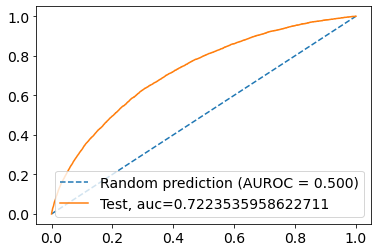

In [61]:
roc_auc = metrics.auc(fpr, tpr)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

# LightGBM Model

In [62]:
clf = lgb.LGBMClassifier(nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,)
clf.fit(X_train_clean, y_train, eval_set=[(X_train_clean, y_train), (X_test_clean, y_test)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.75818	training's binary_logloss: 0.246912	valid_1's auc: 0.743987	valid_1's binary_logloss: 0.250358
[400]	training's auc: 0.773452	training's binary_logloss: 0.241988	valid_1's auc: 0.750972	valid_1's binary_logloss: 0.248154
[600]	training's auc: 0.782934	training's binary_logloss: 0.239102	valid_1's auc: 0.752229	valid_1's binary_logloss: 0.247758
[800]	training's auc: 0.79044	training's binary_logloss: 0.236756	valid_1's auc: 0.752209	valid_1's binary_logloss: 0.24776
Early stopping, best iteration is:
[653]	training's auc: 0.785021	training's binary_logloss: 0.238459	valid_1's auc: 0.75235	valid_1's binary_logloss: 0.247723


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [63]:
# predict the results
y_pred=clf.predict(X_test_clean)

In [64]:
# view accuracy
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9195


In [65]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_train_clean, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test_clean, y_test)))

Training set score: 0.9199
Test set score: 0.9195


In [66]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[84739    66]
 [ 7356    92]]

True Positives(TP) =  84739

True Negatives(TN) =  92

False Positives(FP) =  66

False Negatives(FN) =  7356


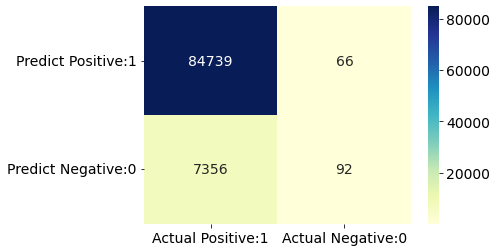

In [67]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [68]:
y_pred_train = clf.predict(X_train_clean)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    197877
           1       0.67      0.01      0.03     17377

    accuracy                           0.92    215254
   macro avg       0.80      0.51      0.49    215254
weighted avg       0.90      0.92      0.88    215254



In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84805
           1       0.58      0.01      0.02      7448

    accuracy                           0.92     92253
   macro avg       0.75      0.51      0.49     92253
weighted avg       0.89      0.92      0.88     92253



In [70]:
r_probs = [0 for _ in range(len(y_test))]
lgbm_probs = clf.predict_proba(X_test_clean)

lgbm_probs = lgbm_probs[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)

In [71]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('LightGBM: AUROC = %.5f' % (lgbm_auc))

Random (chance) Prediction: AUROC = 0.500
LightGBM: AUROC = 0.75235


In [72]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)

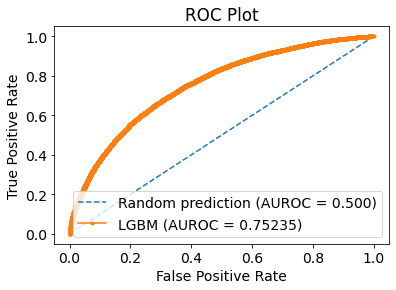

In [73]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM (AUROC = %0.5f)' % lgbm_auc)

plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

dari hasil uji 2 model diatas berdasarkan AUCROC score dan tanpa sampling method, LightGBM terlihat lebih bagus dibanding 
Logistic Regression. <br><br>
AUCROC score :
> 1. Logreg = 0.72
> 2. LightGBM = 0.75 

# With Sampling Method.

In [75]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC

rus = RandomUnderSampler(sampling_strategy=1/3,random_state=42)
ros = RandomOverSampler(sampling_strategy={0.0:3*24825, 1.0:3*24825}, random_state=42)

X_rus, y_rus = rus.fit_resample(X_train_clean,y_train)
X_rus, y_rus = ros.fit_resample(X_rus,y_rus)

y_rus.value_counts()

0    74475
1    74475
Name: TARGET, dtype: int64

In [77]:
num_C = list(np.power(10.0, np.arange(-10, 10)))
cv_num = KFold(n_splits=10, shuffle=True, random_state=42)

clf = linear_model.LogisticRegressionCV(
          Cs= num_C
          ,penalty='l2'
          ,scoring='roc_auc'
          ,cv=cv_num
          ,random_state=42
          ,max_iter=10000
          ,fit_intercept=True
          ,solver='newton-cg'
          ,tol=10
      )
clf.fit(X_rus, y_rus)

#find predicted vallues
y_pred_l2_train = clf.predict(X_rus)
y_pred_l2_test = clf.predict(X_test_clean)


#Find predicted probabilities
y_pred_probs_l2_train = clf.predict_proba(X_rus)[:,1] 
y_pred_probs_l2_test = clf.predict_proba(X_test_clean)[:,1] 


# Accuaracy of L2/L1 models
Accuracy_l2_train = metrics.accuracy_score(y_pred=y_pred_l2_train, y_true=y_rus)
Accuracy_l2_test = metrics.accuracy_score(y_pred=y_pred_l2_test, y_true=y_test)


print("Train Accuracy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2_train))
print("Test Accuracy of Logistic model with l2 regularisation : {0}".format(Accuracy_l2_test))

from sklearn.metrics import roc_auc_score

l2_roc_value_train = roc_auc_score(y_rus, y_pred_probs_l2_train)
print("l2 roc_value: {0}" .format(l2_roc_value_train))
fpr, tpr, thresholds = metrics.roc_curve(y_rus, y_pred_probs_l2_train)
threshold_train_l2 = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold_train_l2))


l2_roc_value_test = roc_auc_score(y_test, y_pred_probs_l2_test)
print("l2 roc_value: {0}" .format(l2_roc_value_test))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2_test)
threshold_test_l2 = thresholds[np.argmax(tpr-fpr)]
print("l2 threshold: {0}".format(threshold_test_l2))


print("classification Report Train")
print(classification_report(y_rus, y_pred_l2_train>threshold_train_l2))

print("classification Report Test")
print(classification_report(y_test, y_pred_l2_test>threshold_test_l2))

Train Accuracy of Logistic model with l2 regularisation : 0.663799932863377
Test Accuracy of Logistic model with l2 regularisation : 0.671598755596024
l2 roc_value: 0.7225862725550827
l2 threshold: 0.48440709600425663
l2 roc_value: 0.7221424033945063
l2 threshold: 0.5094152259264985
classification Report Train
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     74475
           1       0.67      0.65      0.66     74475

    accuracy                           0.66    148950
   macro avg       0.66      0.66      0.66    148950
weighted avg       0.66      0.66      0.66    148950

classification Report Test
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     84805
           1       0.15      0.65      0.24      7448

    accuracy                           0.67     92253
   macro avg       0.55      0.66      0.52     92253
weighted avg       0.89      0.67      0.75     92253



In [78]:
r_probs = [0 for _ in range(len(y_test))]
r_auc = roc_auc_score(y_test, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)

ROC for the test dataset 72.2%


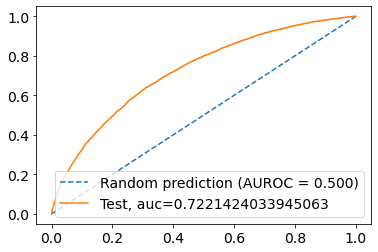

In [79]:
roc_auc = metrics.auc(fpr, tpr)
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [80]:
clf = lgb.LGBMClassifier(nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,)
clf.fit(X_rus, y_rus,eval_set=[(X_rus, y_rus), (X_test_clean, y_test)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.765932	training's binary_logloss: 0.581423	valid_1's auc: 0.741781	valid_1's binary_logloss: 0.593131
[400]	training's auc: 0.787095	training's binary_logloss: 0.560067	valid_1's auc: 0.748375	valid_1's binary_logloss: 0.581411
[600]	training's auc: 0.801631	training's binary_logloss: 0.546289	valid_1's auc: 0.749166	valid_1's binary_logloss: 0.576034
Early stopping, best iteration is:
[534]	training's auc: 0.797133	training's binary_logloss: 0.550511	valid_1's auc: 0.749251	valid_1's binary_logloss: 0.577562


LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02, max_depth=8,
               min_child_weight=39.3259775, min_split_gain=0.0222415,
               n_estimators=10000, nthread=4, num_leaves=34,
               reg_alpha=0.041545473, reg_lambda=0.0735294, silent=-1,
               subsample=0.8715623, verbose=-1)

In [81]:
# predict the results
y_pred=clf.predict(X_test_clean)

In [82]:
# view accuracy
from sklearn.metrics import accuracy_score

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6948


In [83]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(X_rus, y_rus)))

print('Test set score: {:.4f}'.format(clf.score(X_test_clean, y_test)))

Training set score: 0.7203
Test set score: 0.6948


In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[59100 25705]
 [ 2447  5001]]

True Positives(TP) =  59100

True Negatives(TN) =  5001

False Positives(FP) =  25705

False Negatives(FN) =  2447


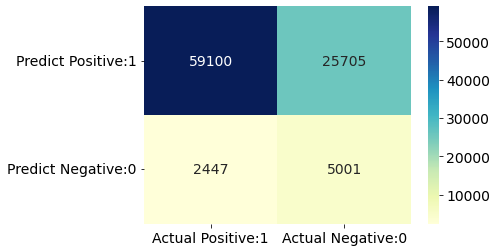

In [85]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [86]:
y_pred_train = clf.predict(X_rus)
print(classification_report(y_rus, y_pred_train))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72     74475
           1       0.72      0.73      0.72     74475

    accuracy                           0.72    148950
   macro avg       0.72      0.72      0.72    148950
weighted avg       0.72      0.72      0.72    148950



In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     84805
           1       0.16      0.67      0.26      7448

    accuracy                           0.69     92253
   macro avg       0.56      0.68      0.53     92253
weighted avg       0.90      0.69      0.76     92253



In [88]:
r_probs = [0 for _ in range(len(y_test))]
lgbm_probs = clf.predict_proba(X_test_clean)

lgbm_probs = lgbm_probs[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
lgbm_auc = roc_auc_score(y_test, lgbm_probs)

In [89]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('LightGBM: AUROC = %.5f' % (lgbm_auc))

Random (chance) Prediction: AUROC = 0.500
LightGBM: AUROC = 0.74925


In [90]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_probs)

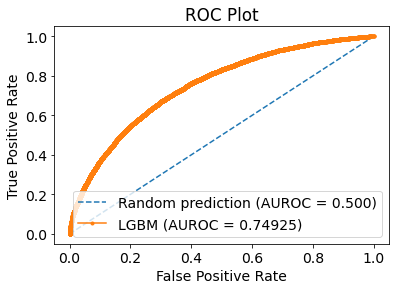

In [91]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(lgbm_fpr, lgbm_tpr, marker='.', label='LGBM (AUROC = %0.5f)' % lgbm_auc)

plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

dari hasil uji 2 model diatas berdasarkan AUCROC score dengan sampling method, LightGBM masih terlihat lebih bagus dibanding 
Logistic Regression. walaupun ada sedikit penurunan pada AUCROC score.<br><br>

beberapa forum mengatakan untuk LightGBM memang bagus untuk penanganan data imbalance dan juga sebenarnya bila kita memang hanya ingin menggunakan 1 model saja yaitu LightGBM.
kita tidak perlu imputation Missing value, karna model tersebut meng "ignore" missing value. itulah kenapa banyak orang pakai LightGBM model.<br><br>
AUCROC score :
> 1. Logreg = 0.72
> 2. LightGBM = 0.74925

In [92]:
import joblib

filename = '/content/drive/MyDrive/Home Credit Rakamin/LGBM_model_ricky.sav'
joblib.dump(clf, filename)

['/content/drive/MyDrive/Home Credit Rakamin/LGBM_model_ricky.sav']

In [93]:
LGBM_model = joblib.load('/content/drive/MyDrive/Home Credit Rakamin/LGBM_model_ricky.sav')
print(LGBM_model.score(X_test_clean, y_test))

0.6948391922213911
